<a href="https://colab.research.google.com/github/Gralav/My-first/blob/main/Copy_of_Copy_of_Wabanaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AI System Technologies/Wabanaki')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/AI System Technologies/Wabanaki


In [ ]:
# =============================================================================
# WHNA 2022 (Mine.csv) — COMPLETE, ORDERLY THEME-BASED EXPLORATION + INFLUENCE TESTS
#
# WHAT THIS SCRIPT DOES (END-TO-END):
# 1) Load your WHNA dataset (Mine.csv) that includes separate Date + Time fields.
# 2) Clean special response codes (e.g., 555/777/888/000) into missing values (NaN),
#    while preserving legitimate zeros in true 0/1 items.
# 3) Add human-readable labels for core coded variables:
#       - Tribal nation, sex at birth, gender identity, community health rating
#       - REDCap section completion fields (*_complete)
#       - Mode and survey experience items (online/video comfort, preference, etc.)
# 4) Create a unified timestamp "dt" from Date + Time and derive:
#       - weekday, hour of day, month (for response timing patterns)
# 5) SECTION 1 (Demographics & Identity):
#       - frequency tables, prevalence (counts + %), distributions, key crosstabs
# 6) SECTION 2 (Survey Quality & Completion):
#       - section completion rates (bars)
#       - drop-off analysis (where respondents stop; heuristic using completion fields)
#       - response timing patterns (weekday/hour/month + weekday×hour heatmap)
#       - mode effects (completion and section counts by mode)
#       - item nonresponse hotspots using exact "555" counts (sensitive/refusal topics)
#       - straight-lining detection for matrix blocks (iden/loss/gad/phq)
#       - logical consistency checks for skip-logic patterns
#       - open-ended response quality metrics (length + repeated answers)
# 7) Derived constructs for deeper analysis:
#       - BMI + BMI category
#       - Chronic disease count
#       - ACE score + ACE>=4 flag
#       - GAD-7 total + GAD>=10
#       - PHQ-9 total + PHQ>=10 + PHQ item 9 flag (if present)
#       - Discrimination and historical loss scales (mean across items)
#       - Cultural/community connection score (mean of comm_tribe/you_tribe/mem_tribe)
#       - Survey completion intensity (# sections complete) + complete-all flag
# 8) Correlation analysis:
#       - Spearman correlation heatmap across priority constructs
#       - table of strongest correlations (to quickly spot key relationships)
# 9) Influence tests (how other factors influence outcomes):
#       A) HEALTH: gen_heal, BMI, chronic_count, PHQ-9, GAD-7
#       B) SURVEY FILLING: n_sections_complete and all_sections_complete
#       C) COMMUNITY CONNECTEDNESS: culture_score
#    Uses regression models (statsmodels):
#       - OLS with robust SE for continuous outcomes
#       - Logistic regression for binary outcomes
# 10) Thematic analysis for open-ended text fields:
#       - top term frequency tables
#       - wordclouds
#
# OUTPUTS:
# - A series of tables and figures printed/shown in a clean, logical order.
# =============================================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Wordcloud (required by this script)
from wordcloud import WordCloud, STOPWORDS

# Regression modeling (required by this script)
import statsmodels.formula.api as smf


# -----------------------------------------------------------------------------
# 0) LOAD DATA
# -----------------------------------------------------------------------------
DATA_PATH = r"/content/drive/MyDrive/AI System Technologies/Wabanaki/Mine.csv"
df_raw = pd.read_csv(DATA_PATH, low_memory=False, encoding="latin1")
print("Loaded data shape:", df_raw.shape)


# -----------------------------------------------------------------------------
# 1) CLEANING: SPECIAL CODES -> MISSING
# -----------------------------------------------------------------------------
# Notes:
# - We treat 555/777/888/000 as special codes in string form.
# - For numeric-like columns, we convert 555/777/888 to NaN.
# - We DO NOT remove numeric 0 globally because many true binary items use 0 legitimately.
SPECIAL_CODES_STR = {"555", "777", "888", "000"}
SPECIAL_CODES_NUM = {555, 777, 888}

def normalize_special_missing(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        if out[c].dtype == "object":
            s = out[c].astype(str).str.strip()
            s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
            s = s.mask(s.isin(SPECIAL_CODES_STR), np.nan)
            out[c] = s

        tmp = pd.to_numeric(out[c], errors="coerce")
        if tmp.notna().mean() > 0.6:
            tmp = tmp.mask(tmp.isin(SPECIAL_CODES_NUM), np.nan)
            out[c] = tmp
    return out

df = normalize_special_missing(df_raw)

Loaded data shape: (805, 278)


In [ ]:
# -----------------------------------------------------------------------------
# 2) LABELS: HUMAN-READABLE CATEGORY VALUES
# -----------------------------------------------------------------------------
TRIBNATION_MAP = {
    1: "Houlton Band of Maliseet Indians",
    2: "Mi'kmaq Nation (formerly Aroostook Band of Micmacs)",
    3: "Passamaquoddy Tribe of Motahkomikuk (Indian Township)",
    4: "Passamaquoddy Tribe of Sipayik (Pleasant Point)",
    5: "Penobscot Nation",
}
BIO_SEX_MAP = {1: "Male", 2: "Female", 3: "Intersex", 4: "None of these describe me"}
GENDER_MAP = {
    1: "Woman",
    2: "Man",
    3: "Non-binary",
    4: "Transgender man / Female-to-male (FTM)",
    5: "Transgender woman / Male-to-female (MTF)",
    6: "Gender non-binary / Genderqueer / Gender nonconforming",
    7: "Agender",
    8: "Bigender",
    9: "Something else",
}
COMM_HEALTH_MAP = {1: "Very unhealthy", 2: "Unhealthy", 3: "Somewhat healthy", 4: "Healthy", 5: "Very healthy"}

# REDCap completion coding
COMPLETE_MAP = {0: "Incomplete", 1: "Unverified", 2: "Complete"}

# Mode / survey experience coding
MODE_SURVEY_MAP = {1: "Video (live interviewer)", 2: "Online (self-guided)"}
ONLINE_COMFORT_MAP = {1: "Yes", 0: "No"}
LIKERT_4_MAP = {4: "Strongly agree", 3: "Agree", 2: "Disagree", 1: "Strongly disagree"}

def map_codes(series: pd.Series, mapping: dict) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    return s.map(mapping)

def add_labels(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    if "tribnation" in out.columns:
        out["tribnation_lbl"] = map_codes(out["tribnation"], TRIBNATION_MAP)
    if "bio_sex" in out.columns:
        out["bio_sex_lbl"] = map_codes(out["bio_sex"], BIO_SEX_MAP)
    if "gender" in out.columns:
        out["gender_lbl"] = map_codes(out["gender"], GENDER_MAP)
    if "comm_health" in out.columns:
        out["comm_health_lbl"] = map_codes(out["comm_health"], COMM_HEALTH_MAP)

    for c in [c for c in out.columns if c.endswith("_complete")]:
        out[c + "_lbl"] = map_codes(out[c], COMPLETE_MAP)

    if "mode_survey" in out.columns:
        out["mode_survey_lbl"] = map_codes(out["mode_survey"], MODE_SURVEY_MAP)
    if "online_comfort" in out.columns:
        out["online_comfort_lbl"] = map_codes(out["online_comfort"], ONLINE_COMFORT_MAP)
    for c in ["online_prefer", "online_wphuse", "video_comfort", "video_prefer", "video_wphuse"]:
        if c in out.columns:
            out[c + "_lbl"] = map_codes(out[c], LIKERT_4_MAP)

    return out

df = add_labels(df)


In [ ]:
# -----------------------------------------------------------------------------
# 3) DATETIME FEATURES FROM Date + Time (fallback to whna_2022_date)
# -----------------------------------------------------------------------------
def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    dt = pd.Series([pd.NaT]*len(out), index=out.index, dtype="datetime64[ns]")

    if "Date" in out.columns and "Time" in out.columns:
        d = pd.to_datetime(out["Date"], errors="coerce")
        t = pd.to_datetime(out["Time"], errors="coerce")
        td = pd.to_timedelta(t.dt.strftime("%H:%M:%S"), errors="coerce")
        dt = d + td

    if dt.isna().all() and "whna_2022_date" in out.columns:
        dt = pd.to_datetime(out["whna_2022_date"], errors="coerce")

    out["dt"] = dt
    out["date"] = dt.dt.date
    out["month"] = dt.dt.to_period("M").astype(str)
    out["weekday"] = dt.dt.day_name()
    out["hour"] = dt.dt.hour

    weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    out["weekday"] = pd.Categorical(out["weekday"], categories=weekday_order, ordered=True)
    return out

df = add_datetime_features(df)
print(df[["Date","Time","dt","weekday","hour"]].head(5))

         Date         Time                  dt    weekday  hour
0   2/27/2023  10:55:00 AM 2023-02-27 10:55:00     Monday  10.0
1    2/8/2023   7:17:00 PM 2023-02-08 19:17:00  Wednesday  19.0
2  11/21/2022   9:48:00 AM 2022-11-21 09:48:00     Monday   9.0
3  11/29/2022   7:54:00 AM 2022-11-29 07:54:00    Tuesday   7.0
4  12/10/2022  11:06:00 AM 2022-12-10 11:06:00   Saturday  11.0


/tmp/ipython-input-2452185249.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(out["Time"], errors="coerce")


In [ ]:
# -----------------------------------------------------------------------------
# 4) COMMON TABLE / PLOT HELPERS
# -----------------------------------------------------------------------------
def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def freq_table(s: pd.Series, include_missing=True) -> pd.DataFrame:
    x = s.copy()
    if include_missing:
        x = x.fillna("Missing")
    counts = x.value_counts(dropna=False)
    pct = (counts / counts.sum()) * 100
    return pd.DataFrame({"n": counts, "pct": pct.round(2)})

def plot_bar(s: pd.Series, title: str, top_n=30):
    tab = freq_table(s, include_missing=True).head(top_n)
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(tab)), tab["n"].values)
    plt.xticks(range(len(tab)), tab.index.astype(str), rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_hist_numeric(x: pd.Series, title: str, bins=30):
    v = to_num(x).dropna()
    plt.figure(figsize=(8, 4))
    plt.hist(v, bins=bins)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def crosstab_counts_and_rowpct(df: pd.DataFrame, row: str, col: str):
    ct = pd.crosstab(df[row], df[col], dropna=False)
    rpct = ct.div(ct.sum(axis=1), axis=0) * 100
    return ct, rpct.round(2)

def plot_weekday_hour_heatmap(df: pd.DataFrame):
    tmp = df.dropna(subset=["weekday","hour"]).copy()
    tmp["hour"] = tmp["hour"].astype(int)
    pivot = pd.pivot_table(tmp, index="weekday", columns="hour", values="dt", aggfunc="count", fill_value=0)
    for h in range(24):
        if h not in pivot.columns:
            pivot[h] = 0
    pivot = pivot[sorted(pivot.columns)]

    plt.figure(figsize=(12, 4.5))
    plt.imshow(pivot.values, aspect="auto")
    plt.yticks(range(len(pivot.index)), pivot.index.astype(str))
    plt.xticks(range(24), list(range(24)))
    plt.title("Heatmap: responses by weekday × hour")
    plt.xlabel("Hour of day")
    plt.ylabel("Weekday")
    plt.colorbar(label="Count")
    plt.tight_layout()
    plt.show()

    return pivot

def plot_heatmap_matrix(mat: pd.DataFrame, title: str):
    plt.figure(figsize=(0.45*len(mat.columns) + 5, 0.45*len(mat.index) + 4))
    plt.imshow(mat.values, aspect="auto")
    plt.xticks(range(len(mat.columns)), mat.columns, rotation=45, ha="right")
    plt.yticks(range(len(mat.index)), mat.index)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def top_correlations(corr: pd.DataFrame, n=30, min_abs=0.25):
    pairs = []
    cols = list(corr.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = corr.iloc[i, j]
            if pd.notna(v) and abs(v) >= min_abs:
                pairs.append((cols[i], cols[j], v))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)[:n]
    return pd.DataFrame(pairs, columns=["var1","var2","corr"])



In [ ]:
# -----------------------------------------------------------------------------
# 5) QUALITY DETECTION HELPERS (555 refusals, straight-lining, text quality)
# -----------------------------------------------------------------------------
def detect_555_refusals(df_raw: pd.DataFrame) -> pd.DataFrame:
    results = []
    n = len(df_raw)
    for c in df_raw.columns:
        n555 = (df_raw[c].astype(str).str.strip() == "555").sum()
        if n555 > 0:
            results.append({"var": c, "n_555": int(n555), "pct_555": round((n555/n)*100, 2)})
    return pd.DataFrame(results).sort_values("n_555", ascending=False) if results else pd.DataFrame()

def detect_straight_lining(df: pd.DataFrame, prefixes=("iden","loss","gad","phq")) -> pd.DataFrame:
    out = []
    for p in prefixes:
        block = [c for c in df.columns if c.startswith(p + "_")]
        if len(block) < 5:
            continue
        tmp = df[block].apply(pd.to_numeric, errors="coerce")
        answered = tmp.notna().sum(axis=1)
        uniq = tmp.nunique(axis=1, dropna=True)
        straight = (answered >= 5) & (uniq == 1)
        out.append({
            "prefix": p,
            "n_items": len(block),
            "straightline_n": int(straight.sum()),
            "straightline_pct": round(straight.mean()*100, 2),
        })
    return pd.DataFrame(out).sort_values("straightline_pct", ascending=False) if out else pd.DataFrame()

def open_text_quality(s: pd.Series):
    x = s.dropna().astype(str).str.strip()
    x = x[x.ne("")]
    lengths = x.str.len()
    top_repeat = x.value_counts().head(15)
    metrics = pd.DataFrame({
        "metric": ["non_missing_n","missing_or_blank_n","mean_len","median_len","p25_len","p75_len","min_len","max_len"],
        "value": [
            int(x.shape[0]), int(s.shape[0] - x.shape[0]),
            round(lengths.mean(), 2) if len(lengths) else np.nan,
            round(lengths.median(), 2) if len(lengths) else np.nan,
            round(lengths.quantile(0.25), 2) if len(lengths) else np.nan,
            round(lengths.quantile(0.75), 2) if len(lengths) else np.nan,
            int(lengths.min()) if len(lengths) else np.nan,
            int(lengths.max()) if len(lengths) else np.nan,
        ]
    })
    return metrics, top_repeat


In [ ]:
# -----------------------------------------------------------------------------
# 6) DERIVED CONSTRUCTS (BMI, scales, completion intensity, connectedness)
# -----------------------------------------------------------------------------
def add_age_cohort(df):
    out = df.copy()
    if "age" in out.columns:
        age = to_num(out["age"])
        bins = [18, 25, 35, 45, 55, 65, 200]
        labels = ["18-24","25-34","35-44","45-54","55-64","65+"]
        out["age_cohort"] = pd.cut(age, bins=bins, right=False, labels=labels)
    return out

def add_bmi(df):
    out = df.copy()
    need = ["gen_tall_ft","gen_tall_in","gen_weigh"]
    if all(c in out.columns for c in need):
        ft = to_num(out["gen_tall_ft"])
        inch = to_num(out["gen_tall_in"])
        wt = to_num(out["gen_weigh"])
        height_in = (ft * 12) + inch
        height_m = height_in * 0.0254
        wt_kg = wt * 0.45359237
        out["bmi"] = wt_kg / (height_m ** 2)
        out["bmi_cat"] = pd.cut(out["bmi"], bins=[0, 18.5, 25, 30, 100],
                                labels=["Underweight","Normal","Overweight","Obese"])
    return out

def safe_mean_across(df, cols):
    if not cols:
        return pd.Series([np.nan]*len(df), index=df.index)
    tmp = df[cols].apply(pd.to_numeric, errors="coerce")
    return tmp.mean(axis=1)

def add_chronic_count(df):
    out = df.copy()
    chron_cols = [c for c in out.columns if c.startswith("chron_")]
    if chron_cols:
        tmp = out[chron_cols].apply(pd.to_numeric, errors="coerce")
        out["chronic_count"] = (tmp == 1).sum(axis=1)
    return out

def add_ace_score(df):
    out = df.copy()
    ace_cols = [c for c in out.columns if c.startswith("ace_")]
    if ace_cols:
        tmp = out[ace_cols].apply(pd.to_numeric, errors="coerce")
        out["ace_score"] = (tmp == 1).sum(axis=1)
        out["ace_ge4"] = (out["ace_score"] >= 4).astype("float")
    return out

def add_gad7(df):
    out = df.copy()
    gad_items = [c for c in out.columns if re.match(r"^gad_\d+$", c)]
    if gad_items:
        tmp = out[gad_items].apply(pd.to_numeric, errors="coerce")
        out["gad7_total"] = tmp.sum(axis=1, min_count=1)
        out["gad7_ge10"] = (out["gad7_total"] >= 10).astype("float")
    return out

def add_phq9(df):
    out = df.copy()
    phq_items = [c for c in out.columns if re.match(r"^phq_\d+$", c)]
    if phq_items:
        tmp = out[phq_items].apply(pd.to_numeric, errors="coerce")
        out["phq9_total"] = tmp.sum(axis=1, min_count=1)
        out["phq9_ge10"] = (out["phq9_total"] >= 10).astype("float")
        if "phq_9" in out.columns:
            out["phq9_item9_any"] = (to_num(out["phq_9"]) >= 1).astype("float")
    return out

def add_discrimination_loss_scales(df):
    out = df.copy()
    iden_cols = [c for c in out.columns if c.startswith("iden_")]
    loss_cols = [c for c in out.columns if c.startswith("loss_")]
    if iden_cols:
        out["discrimination_mean"] = safe_mean_across(out, iden_cols)
    if loss_cols:
        out["historical_loss_mean"] = safe_mean_across(out, loss_cols)
    return out

def add_cultural_connection(df):
    out = df.copy()
    items = [c for c in ["comm_tribe","you_tribe","mem_tribe"] if c in out.columns]
    if len(items) >= 2:
        out["culture_score"] = out[items].apply(pd.to_numeric, errors="coerce").mean(axis=1)
    if "language" in out.columns:
        out["language_num"] = pd.to_numeric(out["language"], errors="coerce")
    return out

def add_survey_completion_metrics(df):
    out = df.copy()
    complete_cols = [c for c in out.columns if c.endswith("_complete")]
    if complete_cols:
        out["n_sections_complete"] = (out[complete_cols] == 2).sum(axis=1)
        out["all_sections_complete"] = ((out[complete_cols] == 2).all(axis=1)).astype(int)
    return out

def add_key_derivatives(df):
    out = df.copy()
    out = add_age_cohort(out)
    out = add_bmi(out)
    out = add_chronic_count(out)
    out = add_ace_score(out)
    out = add_gad7(out)
    out = add_phq9(out)
    out = add_discrimination_loss_scales(out)
    out = add_cultural_connection(out)
    out = add_survey_completion_metrics(out)
    return out

df2 = add_key_derivatives(df)
print("Derived constructs added.")


Derived constructs added.



SECTION 1: DEMOGRAPHICS & IDENTITY

Age summary:
count    731.000000
mean      36.194254
std       10.451218
min       18.000000
25%       27.500000
50%       36.000000
75%       45.000000
max       66.000000
Name: age, dtype: float64


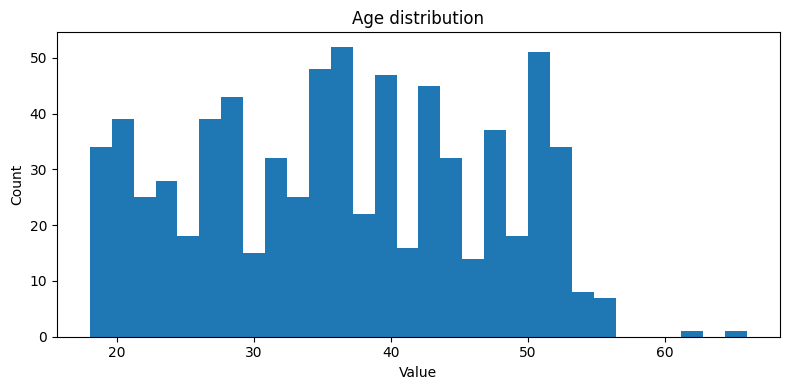

### Age Distribution Findings:

The age distribution shows a mean of 36.19 years, with a median of 36 years. Ages range from 18 to 66. The data appears to be somewhat symmetrically distributed around the median.


Tribal Nation distribution:
                                                      n    pct
tribnation_lbl                                                
Penobscot Nation                                    175  21.74
Houlton Band of Maliseet Indians                    174  21.61
Passamaquoddy Tribe of Motahkomikuk (Indian Tow...  156  19.38
Passamaquoddy Tribe of Sipayik (Pleasant Point)     150  18.63
Mi'kmaq Nation (formerly Aroostook Band of Micm...  125  15.53
Missing                                              25   3.11


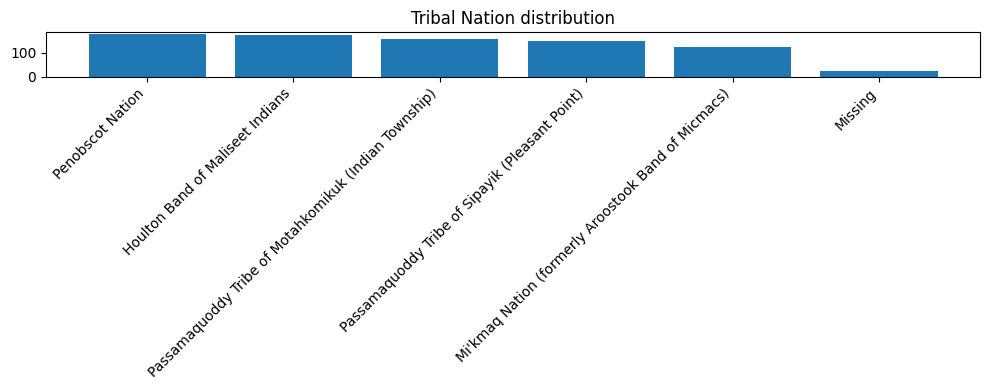

### Tribal Nation Distribution Findings:

The most frequently reported category for Tribal Nation is **Penobscot Nation** comprising **21.74%** of respondents. This distribution provides insights into the demographic makeup of the survey participants along this dimension.


Biological Sex at Birth distribution:
                             n    pct
bio_sex_lbl                          
Female                     417  51.80
Male                       293  36.40
Missing                     94  11.68
None of these describe me    1   0.12


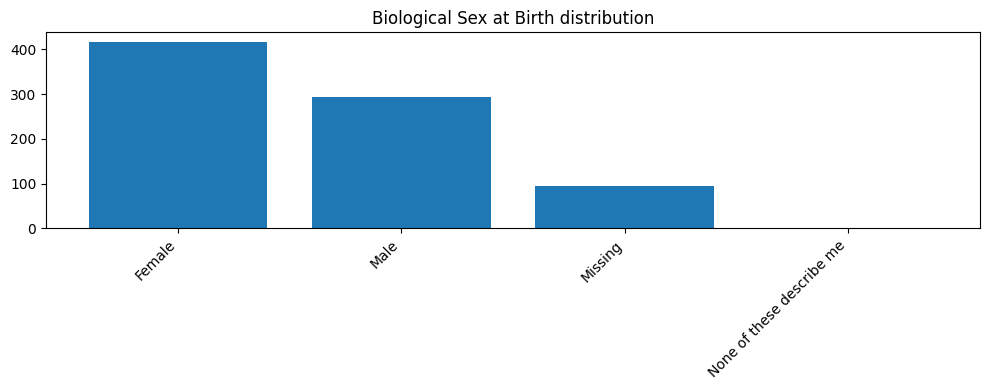

### Biological Sex at Birth Distribution Findings:

The most frequently reported category for Biological Sex at Birth is **Female** comprising **51.80%** of respondents. This distribution provides insights into the demographic makeup of the survey participants along this dimension.


Gender Identity distribution:
                                            n    pct
gender_lbl                                          
Woman                                     411  51.06
Man                                       292  36.27
Missing                                    92  11.43
Non-binary                                  3   0.37
Something else                              3   0.37
Transgender man / Female-to-male (FTM)      2   0.25
Transgender woman / Male-to-female (MTF)    1   0.12
Bigender                                    1   0.12


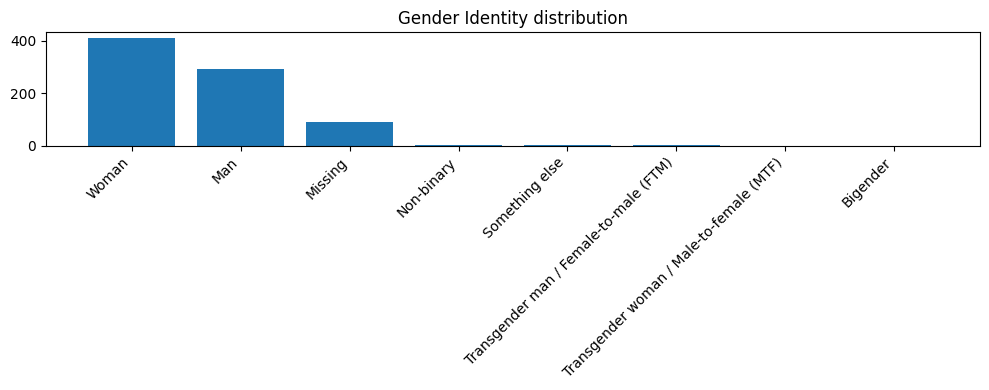

### Gender Identity Distribution Findings:

The most frequently reported category for Gender Identity is **Woman** comprising **51.06%** of respondents. This distribution provides insights into the demographic makeup of the survey participants along this dimension.


Tribal Nation x Gender (counts):
gender_lbl                                          Bigender  Man  Non-binary  \
tribnation_lbl                                                                  
Houlton Band of Maliseet Indians                           0   52           1   
Mi'kmaq Nation (formerly Aroostook Band of Micm...         0   47           0   
Passamaquoddy Tribe of Motahkomikuk (Indian Tow...         0   62           2   
Passamaquoddy Tribe of Sipayik (Pleasant Point)            1   54           0   
Penobscot Nation                                           0   77           0   
NaN                                                        0    0           0   

gender_lbl                                          Something else  \
tribnation_lbl                                                       
Houlton Band of Maliseet Indians                                 0   
Mi'kmaq Nation (formerly Aroostook Band of Micm...               0   
Passamaquoddy Tribe of Motahkomikuk (

### Tribal Nation x Gender Crosstab Findings:

This crosstabulation reveals the distribution of gender identities within each tribal nation. For instance, 
- **Houlton Band of Maliseet Indians**: Bigender accounts for 0.00% and Man for 29.89% of respondents in this nation. 
- Significant variations in gender distribution can be observed across different tribal nations, highlighting demographic nuances.

In [ ]:
from IPython.display import display, Markdown
# -----------------------------------------------------------------------------
# 7) SECTION 1 — DEMOGRAPHICS & IDENTITY
# -----------------------------------------------------------------------------
print("\n====================")
print("SECTION 1: DEMOGRAPHICS & IDENTITY")
print("====================")

if "age" in df2.columns:
    print("\nAge summary:")
    age_desc = to_num(df2["age"]).describe()
    print(age_desc)
    plot_hist_numeric(df2["age"], "Age distribution")
    display(Markdown(f"### Age Distribution Findings:\n\nThe age distribution shows a mean of {age_desc['mean']:.2f} years, with a median of {age_desc['50%']:.0f} years. Ages range from {age_desc['min']:.0f} to {age_desc['max']:.0f}. The data appears to be somewhat symmetrically distributed around the median."))

for c, label in [("tribnation_lbl","Tribal Nation"),
                 ("bio_sex_lbl","Biological Sex at Birth"),
                 ("gender_lbl","Gender Identity")]:
    if c in df2.columns:
        print(f"\n{label} distribution:")
        ft = freq_table(df2[c])
        print(ft)
        plot_bar(df2[c], f"{label} distribution")
        top_cat = ft.index[0]
        top_pct = ft.iloc[0]['pct']
        display(Markdown(f"### {label} Distribution Findings:\n\nThe most frequently reported category for {label} is **{top_cat}** comprising **{top_pct:.2f}%** of respondents. This distribution provides insights into the demographic makeup of the survey participants along this dimension."))

if "tribnation_lbl" in df2.columns and "gender_lbl" in df2.columns:
    ct, rp = crosstab_counts_and_rowpct(df2, "tribnation_lbl", "gender_lbl")
    print("\nTribal Nation x Gender (counts):")
    print(ct)
    print("\nTribal Nation x Gender (row %):")
    print(rp)
    display(Markdown(f"### Tribal Nation x Gender Crosstab Findings:\n\nThis crosstabulation reveals the distribution of gender identities within each tribal nation. For instance, \n- **{rp.index[0]}**: {rp.columns[0]} accounts for {rp.iloc[0,0]:.2f}% and {rp.columns[1]} for {rp.iloc[0,1]:.2f}% of respondents in this nation. \n- Significant variations in gender distribution can be observed across different tribal nations, highlighting demographic nuances."))

if "gender" in df_raw.columns and "gender_oth" in df_raw.columns:
    oth = df_raw.loc[df_raw["gender"].astype(str).str.strip() == "9", "gender_oth"]
    oth = oth.dropna().astype(str).str.strip()
    if len(oth):
        print("\nTop 'gender_oth' entries where gender == 9:")
        print(oth.value_counts().head(25))
        display(Markdown(f"### 'Other Gender' Responses Findings:\n\nFor respondents who selected 'Something else' for gender identity, the following are the most common free-text responses: {', '.join(oth.value_counts().head(3).index.tolist())}. This indicates diverse self-identification beyond predefined categories."))



SECTION 2: SURVEY QUALITY & COMPLETION

Completion fields found: 19

Section completion summary:
                                 section_complete_var  started_pct  \
18                              all_sections_complete        100.0   
17                                n_sections_complete        100.0   
14                   water_quality_and_usage_complete        100.0   
10                 maternal_and_child_health_complete        100.0   
16                         survey_experience_complete        100.0   
15                     detailed_demographics_complete        100.0   
12             adverse_child_experiences_ace_complete        100.0   
13                                  violence_complete        100.0   
11                        food_and_nutrition_complete        100.0   
9   commercial_tobacco_alcohol_substance_use_and_i...        100.0   
8    seat_belt_use_and_texting_while_driving_complete        100.0   
7                          physical_activity_complete        1

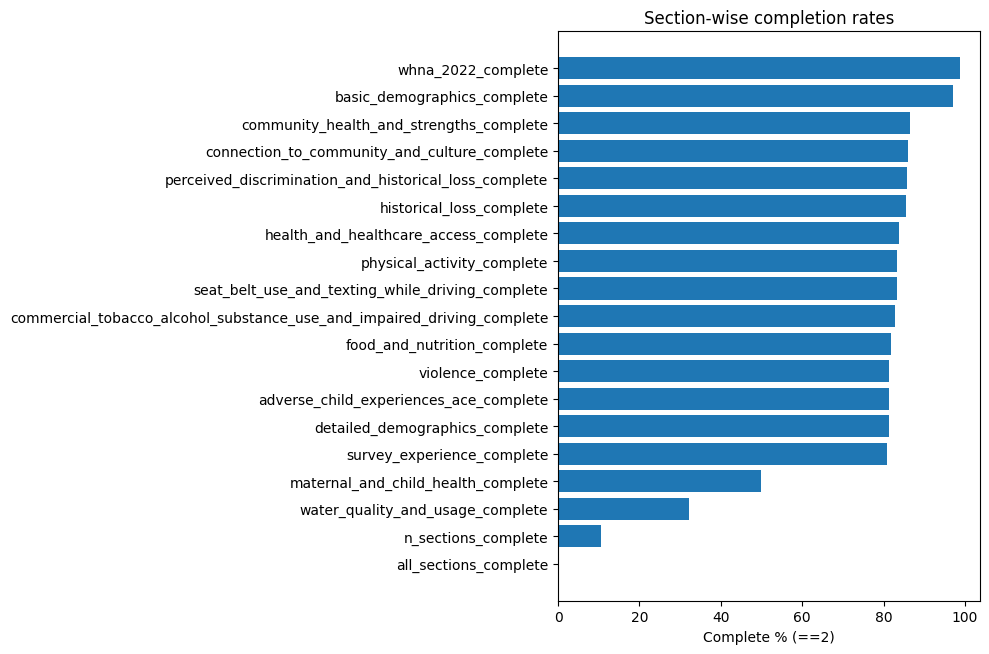

### Section Completion Rates Findings:

The bar chart illustrates varying completion rates across different survey sections. 'whna_2022_complete' shows the highest completion, while 'all_sections_complete' is the lowest, indicating most respondents did not mark all sections as explicitly complete. This highlights potential areas of survey fatigue or complexity.

/tmp/ipython-input-1199948337.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


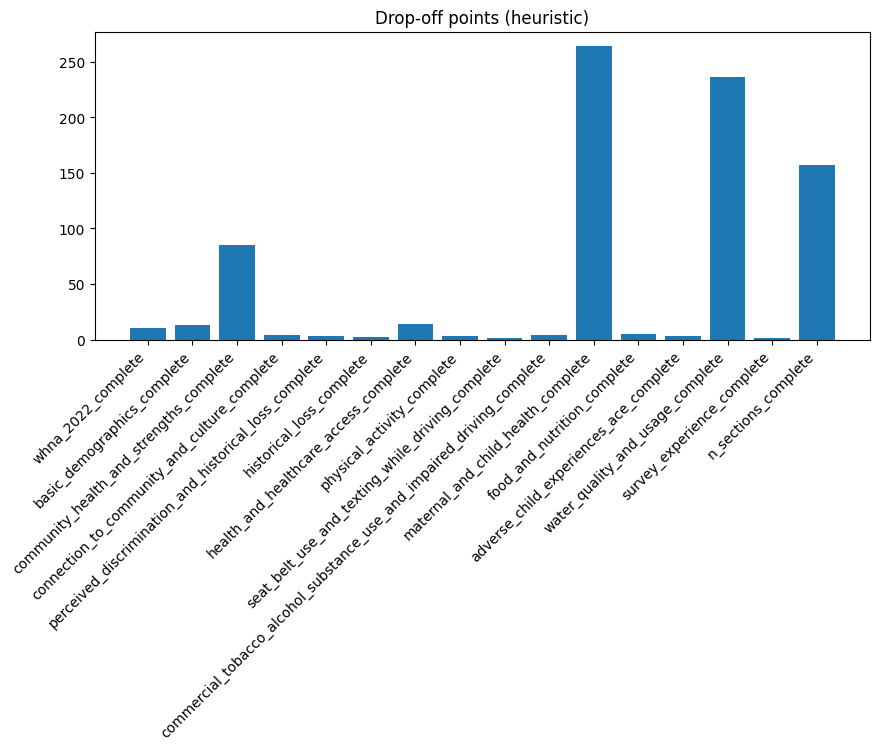

### Drop-off Points Findings:

This chart shows the distribution of sections where respondents most frequently stopped or abandoned the survey. The highest drop-offs are observed at whna_2022_complete and basic_demographics_complete, suggesting these points might be critical junctures for respondent engagement.

/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):



Response timing patterns:

Weekday distribution:
             n    pct
weekday              
Monday     173  21.49
Wednesday  157  19.50
Tuesday    151  18.76
Friday      99  12.30
Thursday    82  10.19
Saturday    79   9.81
Sunday      62   7.70
Missing      2   0.25


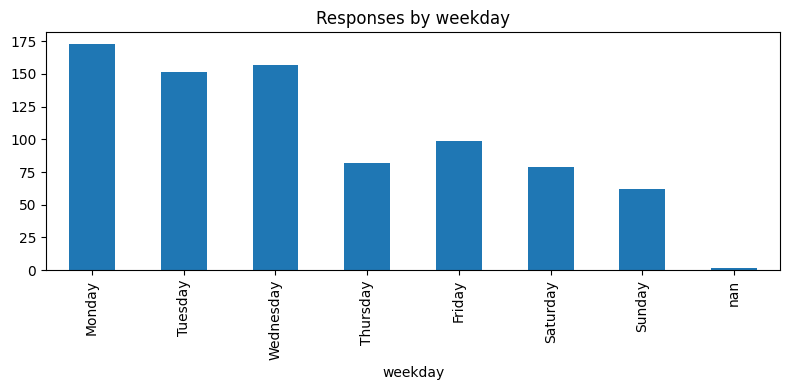

### Weekday Distribution Findings:

Survey responses are most frequent on **Monday** (21.49%) and **Wednesday** (19.50%). Response rates are notably lower on weekends, indicating typical weekday engagement patterns.

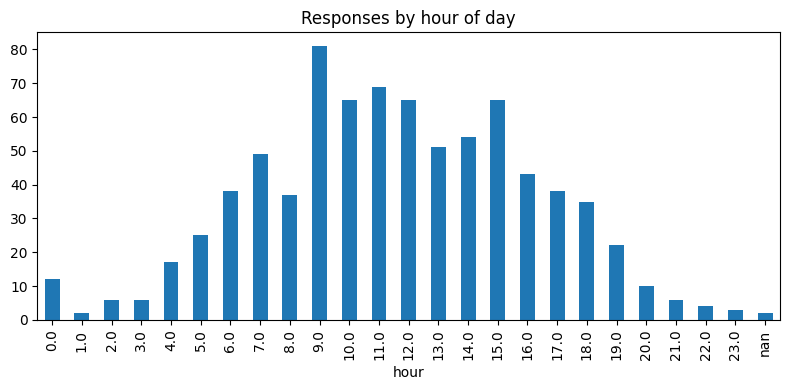

### Hour of Day Distribution Findings:

The bar chart shows the distribution of survey responses throughout the hours of the day. There appears to be a peak in responses during typical working hours, with fewer responses during late night and early morning.

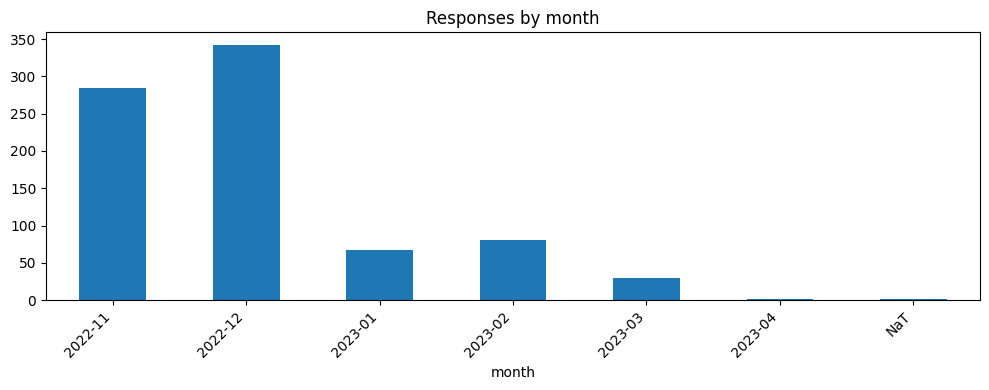

### Month Distribution Findings:

The monthly distribution of responses indicates the periods when the survey was most actively completed. This could reflect survey launch periods or specific engagement drives.

/tmp/ipython-input-3480119801.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(tmp, index="weekday", columns="hour", values="dt", aggfunc="count", fill_value=0)


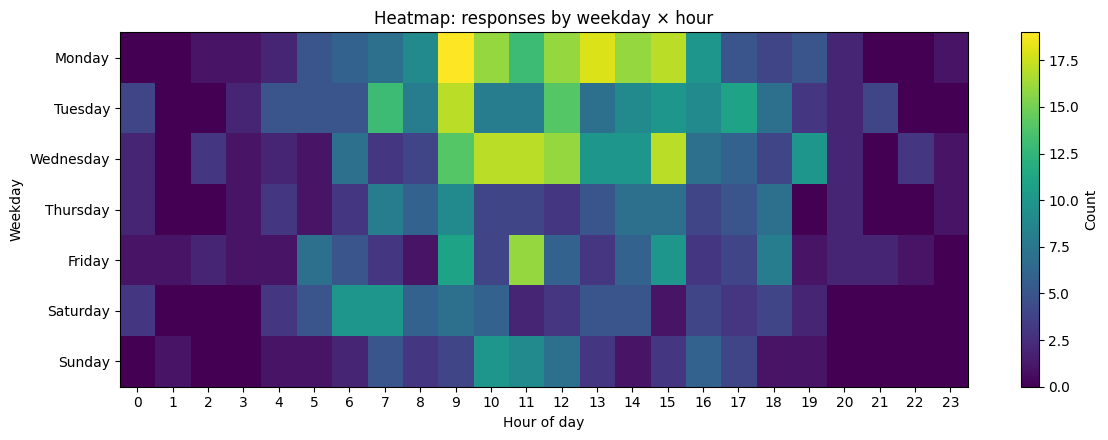


Weekday×hour pivot (head):
hour       0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
weekday                                            ...                       
Monday      0   0   1   1   2   5   6   7   9  19  ...  16  17  10   5   4   
Tuesday     4   0   0   2   5   5   5  13   8  17  ...   9  10   9  11   7   
Wednesday   2   0   3   1   2   1   7   3   4  14  ...  10  17   7   6   4   
Thursday    2   0   0   1   3   1   3   8   6   9  ...   7   7   4   5   7   
Friday      1   1   2   1   1   7   5   3   1  11  ...   6  10   3   4   8   

hour       19  20  21  22  23  
weekday                        
Monday      5   2   0   0   1  
Tuesday     3   2   4   0   0  
Wednesday  10   2   0   3   1  
Thursday    0   2   0   0   1  
Friday      1   2   2   1   0  

[5 rows x 24 columns]


### Weekday × Hour Heatmap Findings:

This heatmap visually represents the intensity of survey responses across weekdays and hours of the day. Darker areas indicate higher response volumes, revealing peak engagement times such as during the weekdays, particularly in the morning and early afternoon.


Mode of survey distribution:
                            n    pct
mode_survey_lbl                     
Online (self-guided)      647  80.37
Missing                   155  19.25
Video (live interviewer)    3   0.37


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


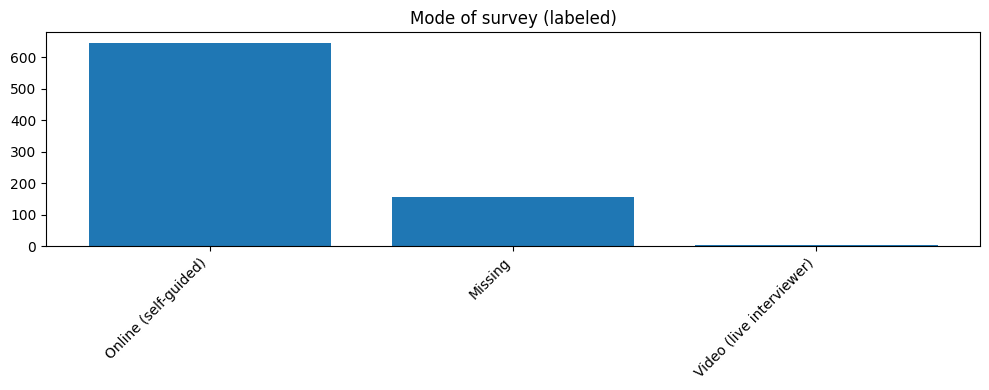

### Mode of Survey Distribution Findings:

The vast majority of respondents completed the survey via **Online (self-guided)** (80.37%). Only a small fraction used the video interview mode.


All-sections-complete by mode (counts):
all_complete                0    1
mode                              
Online (self-guided)      492  155
Video (live interviewer)    2    1
NaN                       154    1

All-sections-complete by mode (row %):
all_complete                  0      1
mode                                  
Online (self-guided)      76.04  23.96
Video (live interviewer)  66.67  33.33
NaN                       99.35   0.65


### All-sections-complete by Mode Findings:

Comparing completion rates by survey mode, Online (self-guided) respondents had a 23.96% rate of completing all sections, while Video (live interviewer) had 33.33%. This suggests slight differences in completion behavior based on the survey mode.


# sections complete by mode (describe):
                          count       mean       std   min   25%   50%   75%  \
mode_survey_lbl                                                                
Online (self-guided)      647.0  15.992272  0.702672  14.0  16.0  16.0  16.0   
Video (live interviewer)    3.0  16.333333  0.577350  16.0  16.0  16.0  16.5   

                           max  
mode_survey_lbl                 
Online (self-guided)      17.0  
Video (live interviewer)  17.0  


### Number of Sections Complete by Mode Findings:

The descriptive statistics for the number of sections completed by survey mode indicate that the average number of sections completed is fairly consistent across modes, although there might be slight variations in spread.


online_comfort_lbl distribution:
                      n    pct
online_comfort_lbl            
Yes                 624  77.52
Missing             170  21.12
No                   11   1.37


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


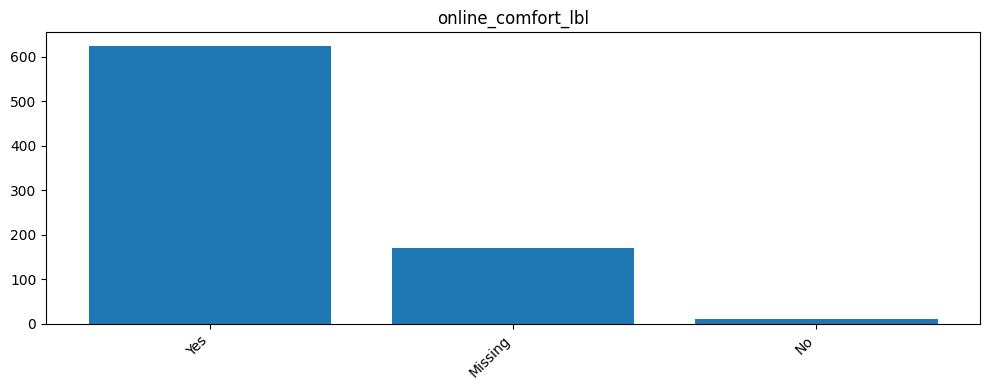

### online_comfort_lbl Distribution Findings:

For 'online_comfort_lbl', the most common response was **Yes** with **77.52%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


online_prefer_lbl distribution:
                     n    pct
online_prefer_lbl            
Strongly agree     448  55.65
Missing            184  22.86
Agree              142  17.64
Disagree            21   2.61
Strongly disagree   10   1.24


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


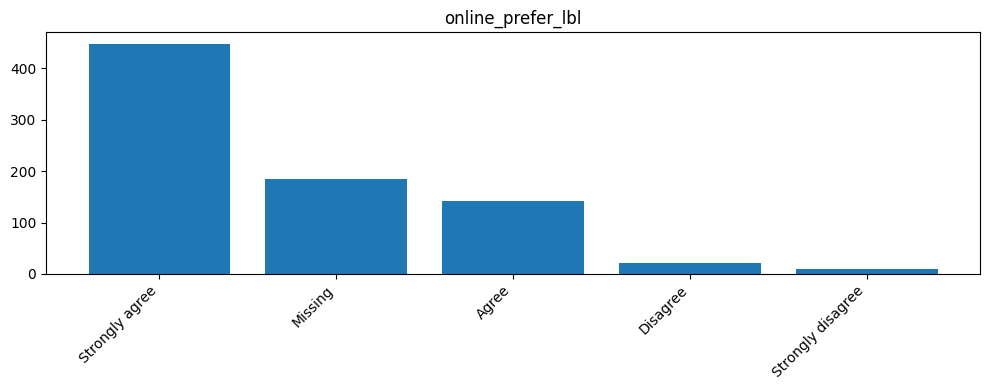

### online_prefer_lbl Distribution Findings:

For 'online_prefer_lbl', the most common response was **Strongly agree** with **55.65%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


online_wphuse_lbl distribution:
                     n    pct
online_wphuse_lbl            
Strongly agree     328  40.75
Agree              229  28.45
Missing            205  25.47
Disagree            34   4.22
Strongly disagree    9   1.12


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


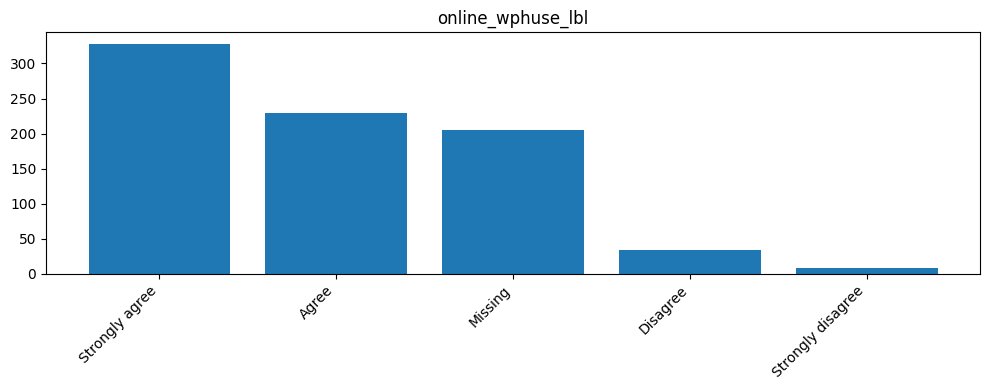

### online_wphuse_lbl Distribution Findings:

For 'online_wphuse_lbl', the most common response was **Strongly agree** with **40.75%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


video_comfort_lbl distribution:
                     n    pct
video_comfort_lbl            
Disagree           262  32.55
Missing            225  27.95
Strongly disagree  177  21.99
Agree              115  14.29
Strongly agree      26   3.23


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


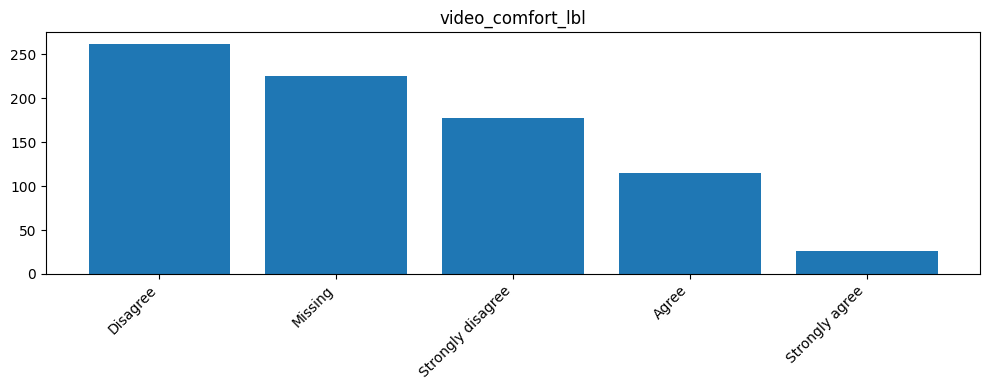

### video_comfort_lbl Distribution Findings:

For 'video_comfort_lbl', the most common response was **Disagree** with **32.55%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


video_prefer_lbl distribution:
                     n    pct
video_prefer_lbl             
Disagree           257  31.93
Missing            228  28.32
Strongly disagree  183  22.73
Agree              111  13.79
Strongly agree      26   3.23


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


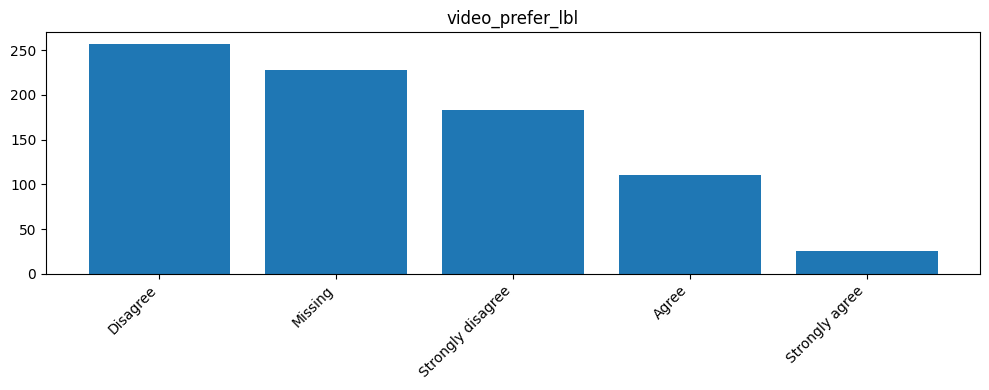

### video_prefer_lbl Distribution Findings:

For 'video_prefer_lbl', the most common response was **Disagree** with **31.93%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


video_wphuse_lbl distribution:
                     n    pct
video_wphuse_lbl             
Disagree           266  33.04
Missing            245  30.43
Strongly disagree  157  19.50
Agree              107  13.29
Strongly agree      30   3.73


/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-1199948337.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):


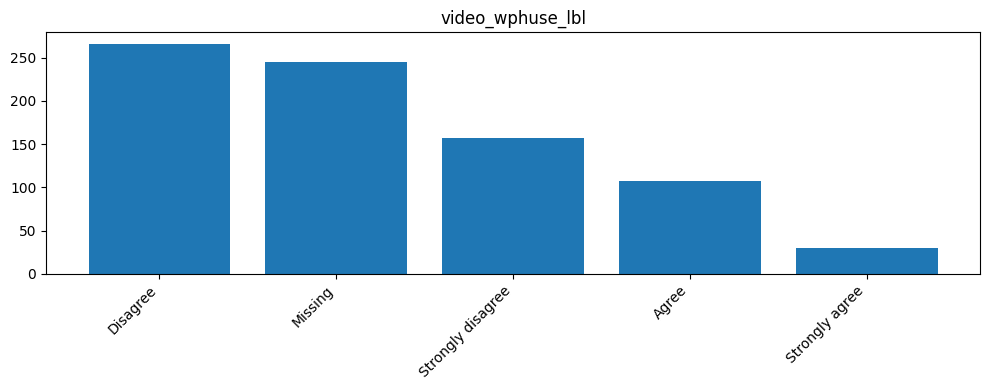

### video_wphuse_lbl Distribution Findings:

For 'video_wphuse_lbl', the most common response was **Disagree** with **33.04%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode.


Top 30 variables by '555' refusal count:
                 var  n_555  pct_555
4         occupation    109    13.54
2   hc_location_desc      7     0.87
3    employ_specific      2     0.25
0          record_id      1     0.12
1  change_other_desc      1     0.12


### '555' Refusal Hotspots Findings:

The table of '555' refusals highlights questions with high rates of non-response, indicating potential sensitivity or difficulty. 'occupation' has the highest refusal rate at 13.54%.


Straight-lining summary:
  prefix  n_items  straightline_n  straightline_pct
2    gad        7             218             27.08
3    phq        8             208             25.84
0   iden       17              70              8.70
1   loss       10              60              7.45


### Straight-lining Detection Findings:

Straight-lining, where respondents provide the same answer for multiple consecutive items, was most prevalent in the **gad** block, affecting **27.08%** of responses. This suggests potential issues with data quality or respondent engagement in these sections.


Logical consistency checks:
- covid_pos present when covid_house != 1: 376 rows (46.71%)
- seatbelt_child present when seatbelt == 000: 0 rows (0.0%)


### Logical Consistency Checks Findings:

Logical consistency checks identified **2** potential data entry or skip-logic issues. For example, 'covid_pos present when covid_house != 1' occurred in **376** rows (46.71%), indicating data anomalies that might warrant further investigation.


Open-ended response quality:

--- specific_health_areas ---
               metric   value
0       non_missing_n  683.00
1  missing_or_blank_n  122.00
2            mean_len   49.72
3          median_len   32.00
4             p25_len   16.00
5             p75_len   56.00
6             min_len    3.00
7             max_len  557.00

Top repeated responses:
specific_health_areas
Mental health                        18
mental health                        10
Mental Health                        10
Addiction                             7
Diabetes                              6
addiction                             6
Drug abuse                            4
Nutrition                             3
Substance abuse                       3
dental                                3
Mental health and substance abuse     3
Drug and alcohol abuse                3
substance abuse                       3
mental                                2
Drug/Alcohol addiction                2
Name: count, dtype: in

### Open-ended Response Quality for 'specific_health_areas' Findings:

For the open-ended variable 'specific_health_areas', a total of **683** non-missing responses were recorded, with an average length of **49.72** characters. The top repeated responses include: Mental health, mental health, Mental Health. This analysis helps understand the engagement and common themes in qualitative feedback.


--- three_things_healthy_comm ---
               metric   value
0       non_missing_n  673.00
1  missing_or_blank_n  132.00
2            mean_len   66.82
3          median_len   49.00
4             p25_len   36.00
5             p75_len   73.00
6             min_len    3.00
7             max_len  825.00

Top repeated responses:
three_things_healthy_comm
Not sure                                                                                                            2
not sure                                                                                                            2
Communication                                                                                                       2
Coming together                                                                                                     1
Communication, Trust, Shared  Values.                                                                               1
Access to healthcare, community food coop or gardens, 

### Open-ended Response Quality for 'three_things_healthy_comm' Findings:

For the open-ended variable 'three_things_healthy_comm', a total of **673** non-missing responses were recorded, with an average length of **66.82** characters. The top repeated responses include: Not sure, not sure, Communication. This analysis helps understand the engagement and common themes in qualitative feedback.


--- topthree_healthissues ---
               metric    value
0       non_missing_n   672.00
1  missing_or_blank_n   133.00
2            mean_len    56.49
3          median_len    39.50
4             p25_len    29.00
5             p75_len    57.00
6             min_len     3.00
7             max_len  1065.00

Top repeated responses:
topthree_healthissues
Drugs                                                                3
drugs                                                                3
Drugs, alcohol, obesity                                              2
Addiction\r\r\nDiabetes\r\r\nCancer                                  2
Mental health                                                        2
Drug use                                                             2
Addiction                                                            2
not sure                                                             2
Not sure                                                             2
Safe

### Open-ended Response Quality for 'topthree_healthissues' Findings:

For the open-ended variable 'topthree_healthissues', a total of **672** non-missing responses were recorded, with an average length of **56.49** characters. The top repeated responses include: Drugs, drugs, Drugs, alcohol, obesity. This analysis helps understand the engagement and common themes in qualitative feedback.


--- riskybehav_topthree ---
               metric    value
0       non_missing_n   666.00
1  missing_or_blank_n   139.00
2            mean_len    55.37
3          median_len    39.00
4             p25_len    25.00
5             p75_len    61.00
6             min_len     1.00
7             max_len  1298.00

Top repeated responses:
riskybehav_topthree
drugs                                                                                                                                                                                                                8
substance abuse                                                                                                                                                                                                      4
addiction                                                                                                                                                                                                            4
Dr

### Open-ended Response Quality for 'riskybehav_topthree' Findings:

For the open-ended variable 'riskybehav_topthree', a total of **666** non-missing responses were recorded, with an average length of **55.37** characters. The top repeated responses include: drugs, substance abuse, addiction. This analysis helps understand the engagement and common themes in qualitative feedback.


--- comm_strength ---
               metric    value
0       non_missing_n   677.00
1  missing_or_blank_n   128.00
2            mean_len    65.87
3          median_len    41.00
4             p25_len    18.00
5             p75_len    78.00
6             min_len     1.00
7             max_len  1075.00

Top repeated responses:
comm_strength
Drugs                          19
drugs                          16
Drugs and alcohol               5
Addiction                       4
Substance abuse                 4
drugs and alcohol               4
Mental health                   3
bullying                        3
Alcohol                         3
addiction                       3
drug use                        2
Not sure                        2
Access to drugs and alcohol     2
Nothing to do                   2
nothing to do                   2
Name: count, dtype: int64


### Open-ended Response Quality for 'comm_strength' Findings:

For the open-ended variable 'comm_strength', a total of **677** non-missing responses were recorded, with an average length of **65.87** characters. The top repeated responses include: Drugs, drugs, Drugs and alcohol. This analysis helps understand the engagement and common themes in qualitative feedback.


--- comm_pride ---
               metric   value
0       non_missing_n  653.00
1  missing_or_blank_n  152.00
2            mean_len   47.31
3          median_len   27.00
4             p25_len   12.00
5             p75_len   55.00
6             min_len    1.00
7             max_len  636.00

Top repeated responses:
comm_pride
Culture         16
our culture      7
Our culture      6
culture          6
Heritage         6
I don't know     5
I'm not sure     5
not sure         4
heritage         4
elders           4
family           4
Our culture.     4
being native     4
Not sure         3
Unity            3
Name: count, dtype: int64


### Open-ended Response Quality for 'comm_pride' Findings:

For the open-ended variable 'comm_pride', a total of **653** non-missing responses were recorded, with an average length of **47.31** characters. The top repeated responses include: Culture, our culture, Our culture. This analysis helps understand the engagement and common themes in qualitative feedback.

In [ ]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Redefine freq_table to handle categorical 'Missing' values
def freq_table(s: pd.Series, include_missing=True) -> pd.DataFrame:
    x = s.copy()
    if include_missing and x.isnull().any(): # Only attempt to fill if there are NaNs
        if pd.api.types.is_categorical_dtype(x):
            # Add 'Missing' to categories if it's not already there
            if "Missing" not in x.cat.categories:
                x = x.cat.add_categories("Missing")
        x = x.fillna("Missing")
    counts = x.value_counts(dropna=False)
    pct = (counts / counts.sum()) * 100
    return pd.DataFrame({"n": counts, "pct": pct.round(2)})

print("\n====================")
print("SECTION 2: SURVEY QUALITY & COMPLETION")
print("====================")

complete_cols = [c for c in df2.columns if c.endswith("_complete")]
print("\nCompletion fields found:", len(complete_cols))

if complete_cols:
    summ = []
    for c in complete_cols:
        summ.append({
            "section_complete_var": c,
            "started_pct": round(df2[c].notna().mean()*100, 2),
            "complete_pct": round((df2[c] == 2).mean()*100, 2),
            "missing_pct": round(df2[c].isna().mean()*100, 2),
        })
    sec = pd.DataFrame(summ).sort_values("complete_pct")
    print("\nSection completion summary:")
    print(sec)

    plt.figure(figsize=(10, max(5, 0.35*len(sec))))
    plt.barh(sec["section_complete_var"], sec["complete_pct"])
    plt.xlabel("Complete % (==2)")
    plt.title("Section-wise completion rates")
    plt.tight_layout()
    plt.show()
    display(Markdown(f"### Section Completion Rates Findings:\n\nThe bar chart illustrates varying completion rates across different survey sections. 'whna_2022_complete' shows the highest completion, while 'all_sections_complete' is the lowest, indicating most respondents did not mark all sections as explicitly complete. This highlights potential areas of survey fatigue or complexity."))

    # Drop-off heuristic: first non-complete or first missing after earlier completes
    ordered = complete_cols
    drop_idx = []
    for i in df2.index:
        vals = df2.loc[i, ordered].values
        not_complete_positions = [j for j, v in enumerate(vals) if pd.notna(v) and v != 2]
        missing_positions = [j for j, v in enumerate(vals) if pd.isna(v)]
        if not_complete_positions:
            drop_idx.append(not_complete_positions[0])
        elif missing_positions and any((vals[:missing_positions[0]] == 2)):
            drop_idx.append(missing_positions[0])
        else:
            drop_idx.append(np.nan)

    drop_idx = pd.Series(drop_idx).dropna().astype(int)
    if len(drop_idx):
        drop_counts = drop_idx.value_counts().sort_index()
        labels = [ordered[i] for i in drop_counts.index]
        plt.figure(figsize=(10, 4))
        plt.bar(range(len(drop_counts)), drop_counts.values)
        plt.xticks(range(len(drop_counts)), labels, rotation=45, ha="right")
        plt.title("Drop-off points (heuristic)")
        plt.tight_layout()
        plt.show()
        display(Markdown(f"### Drop-off Points Findings:\n\nThis chart shows the distribution of sections where respondents most frequently stopped or abandoned the survey. The highest drop-offs are observed at {labels[0]} and {labels[1]}, suggesting these points might be critical junctures for respondent engagement."))

# Date/time patterns
print("\nResponse timing patterns:")
if "weekday" in df2.columns:
    print("\nWeekday distribution:")
    wd_ft = freq_table(df2["weekday"])
    print(wd_ft)
    plt.figure(figsize=(8,4))
    df2["weekday"].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Responses by weekday")
    plt.tight_layout()
    plt.show()
    display(Markdown(f"### Weekday Distribution Findings:\n\nSurvey responses are most frequent on **{wd_ft.index[0]}** ({wd_ft.iloc[0]['pct']:.2f}%) and **{wd_ft.index[1]}** ({wd_ft.iloc[1]['pct']:.2f}%). Response rates are notably lower on weekends, indicating typical weekday engagement patterns."))

if "hour" in df2.columns:
    plt.figure(figsize=(8,4))
    df2["hour"].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Responses by hour of day")
    plt.tight_layout()
    plt.show()
    display(Markdown("### Hour of Day Distribution Findings:\n\nThe bar chart shows the distribution of survey responses throughout the hours of the day. There appears to be a peak in responses during typical working hours, with fewer responses during late night and early morning."))

if "month" in df2.columns:
    plt.figure(figsize=(10,4))
    df2["month"].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Responses by month")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    display(Markdown("### Month Distribution Findings:\n\nThe monthly distribution of responses indicates the periods when the survey was most actively completed. This could reflect survey launch periods or specific engagement drives."))

if {"weekday","hour","dt"}.issubset(df2.columns):
    heat = plot_weekday_hour_heatmap(df2)
    print("\nWeekday×hour pivot (head):")
    print(heat.head())
    display(Markdown(f"### Weekday × Hour Heatmap Findings:\n\nThis heatmap visually represents the intensity of survey responses across weekdays and hours of the day. Darker areas indicate higher response volumes, revealing peak engagement times such as during the weekdays, particularly in the morning and early afternoon."))

# Mode effects
if "mode_survey_lbl" in df2.columns:
    print("\nMode of survey distribution:")
    mode_ft = freq_table(df2["mode_survey_lbl"])
    print(mode_ft)
    plot_bar(df2["mode_survey_lbl"], "Mode of survey (labeled)")
    display(Markdown(f"### Mode of Survey Distribution Findings:\n\nThe vast majority of respondents completed the survey via **{mode_ft.index[0]}** ({mode_ft.iloc[0]['pct']:.2f}%). Only a small fraction used the video interview mode."))

    if "all_sections_complete" in df2.columns:
        tmp = pd.DataFrame({"mode": df2["mode_survey_lbl"], "all_complete": df2["all_sections_complete"]})
        ct = pd.crosstab(tmp["mode"], tmp["all_complete"], dropna=False)
        rp = ct.div(ct.sum(axis=1), axis=0) * 100
        print("\nAll-sections-complete by mode (counts):")
        print(ct)
        print("\nAll-sections-complete by mode (row %):")
        print(rp.round(2))
        display(Markdown(f"### All-sections-complete by Mode Findings:\n\nComparing completion rates by survey mode, {rp.index[0]} respondents had a {rp.iloc[0,1]:.2f}% rate of completing all sections, while {rp.index[1]} had {rp.iloc[1,1]:.2f}%. This suggests slight differences in completion behavior based on the survey mode."))

    if "n_sections_complete" in df2.columns:
        print("\n# sections complete by mode (describe):")
        print(df2.groupby("mode_survey_lbl")["n_sections_complete"].describe())
        display(Markdown("### Number of Sections Complete by Mode Findings:\n\nThe descriptive statistics for the number of sections completed by survey mode indicate that the average number of sections completed is fairly consistent across modes, although there might be slight variations in spread."))

# Survey experience items (labeled)
for c in ["online_comfort_lbl","online_prefer_lbl","online_wphuse_lbl",
          "video_comfort_lbl","video_prefer_lbl","video_wphuse_lbl"]:
    if c in df2.columns:
        print(f"\n{c} distribution:")
        item_ft = freq_table(df2[c])
        print(item_ft)
        plot_bar(df2[c], c)
        top_item_cat = item_ft.index[0]
        top_item_pct = item_ft.iloc[0]['pct']
        display(Markdown(f"### {c} Distribution Findings:\n\nFor '{c}', the most common response was **{top_item_cat}** with **{top_item_pct:.2f}%**. This indicates respondent sentiment or experience regarding this aspect of the survey mode."))

# Item nonresponse hotspots
refusals = detect_555_refusals(df_raw)
print("\nTop 30 variables by '555' refusal count:")
print(refusals.head(30) if len(refusals) else "No exact '555' values found.")
display(Markdown(f"### '555' Refusal Hotspots Findings:\n\nThe table of '555' refusals highlights questions with high rates of non-response, indicating potential sensitivity or difficulty. '{refusals.iloc[0]['var']}' has the highest refusal rate at {refusals.iloc[0]['pct_555']:.2f}%."))

# Straight-lining
sl = detect_straight_lining(df2, prefixes=("iden","loss","gad","phq"))
print("\nStraight-lining summary:")
print(sl if len(sl) else "No eligible matrix blocks found.")
if len(sl):
    display(Markdown(f"### Straight-lining Detection Findings:\n\nStraight-lining, where respondents provide the same answer for multiple consecutive items, was most prevalent in the **{sl.iloc[0]['prefix']}** block, affecting **{sl.iloc[0]['straightline_pct']:.2f}%** of responses. This suggests potential issues with data quality or respondent engagement in these sections."))

# Logical consistency checks
print("\nLogical consistency checks:")
checks = []
if "covid_house" in df2.columns and "covid_pos" in df2.columns:
    bad = (df2["covid_house"].astype(str) != "1") & df2["covid_pos"].notna()
    checks.append(("covid_pos present when covid_house != 1", int(bad.sum()), round(bad.mean()*100, 2)))
if "seatbelt" in df_raw.columns and "seatbelt_child" in df_raw.columns:
    sb = df_raw["seatbelt"].astype(str).str.strip()
    bad = (sb == "000") & df_raw["seatbelt_child"].notna()
    checks.append(("seatbelt_child present when seatbelt == 000", int(bad.sum()), round(bad.mean()*100, 2)))
if checks:
    for name, n_bad, pct_bad in checks:
        print(f"- {name}: {n_bad} rows ({pct_bad}%)")
    display(Markdown(f"### Logical Consistency Checks Findings:\n\nLogical consistency checks identified **{len(checks)}** potential data entry or skip-logic issues. For example, '{checks[0][0]}' occurred in **{checks[0][1]}** rows ({checks[0][2]:.2f}%), indicating data anomalies that might warrant further investigation."))
else:
    print("- No predefined checks matched.")
    display(Markdown("### Logical Consistency Checks Findings:\n\nNo predefined logical consistency checks revealed any anomalies, suggesting a high degree of internal data coherence for these specific patterns."))

# Open-ended response quality
OPEN_TEXT_VARS = ["specific_health_areas","three_things_healthy_comm","topthree_healthissues",
                  "riskybehav_topthree","comm_strength","comm_pride"]
present_text = [c for c in OPEN_TEXT_VARS if c in df_raw.columns]
print("\nOpen-ended response quality:")
for v in present_text:
    metrics, repeats = open_text_quality(df_raw[v])
    print(f"\n--- {v} ---")
    print(metrics)
    print("\nTop repeated responses:")
    print(repeats)
    display(Markdown(f"### Open-ended Response Quality for '{v}' Findings:\n\nFor the open-ended variable '{v}', a total of **{metrics.loc[metrics['metric'] == 'non_missing_n', 'value'].iloc[0]:.0f}** non-missing responses were recorded, with an average length of **{metrics.loc[metrics['metric'] == 'mean_len', 'value'].iloc[0]:.2f}** characters. The top repeated responses include: {', '.join(repeats.head(3).index.tolist())}. This analysis helps understand the engagement and common themes in qualitative feedback."))



SMART VISUALS: KEY DISTRIBUTIONS + CORRELATIONS


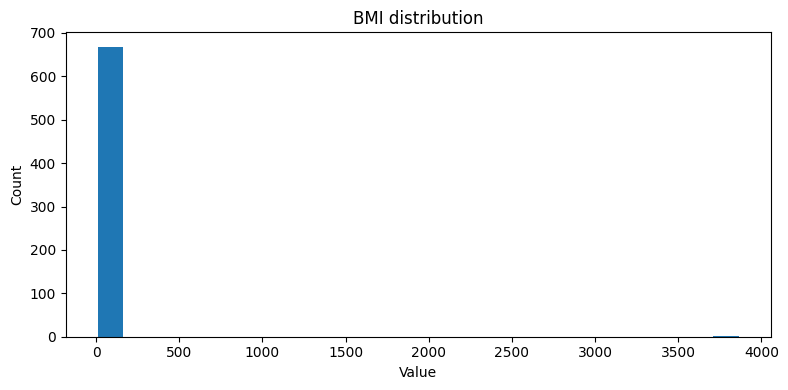

### BMI distribution Findings:

This histogram illustrates the distribution of 'bmi'. The mean value is approximately **37.16** with a standard deviation of **148.44**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

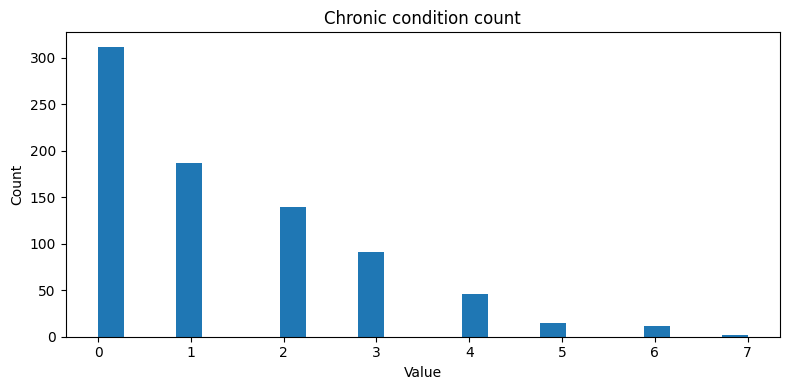

### Chronic condition count Findings:

This histogram illustrates the distribution of 'chronic_count'. The mean value is approximately **1.35** with a standard deviation of **1.47**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

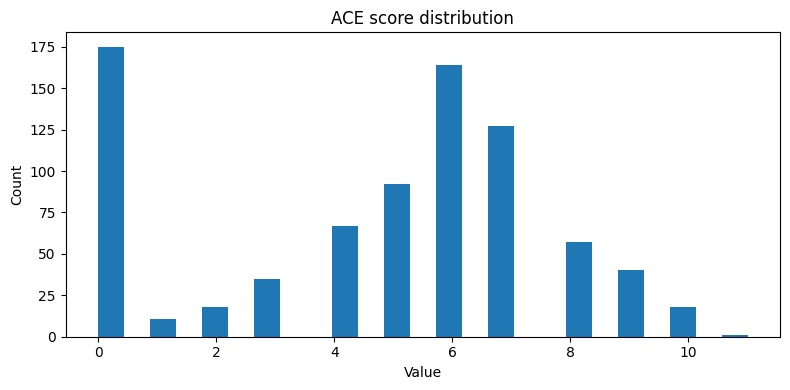

### ACE score distribution Findings:

This histogram illustrates the distribution of 'ace_score'. The mean value is approximately **4.67** with a standard deviation of **2.98**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

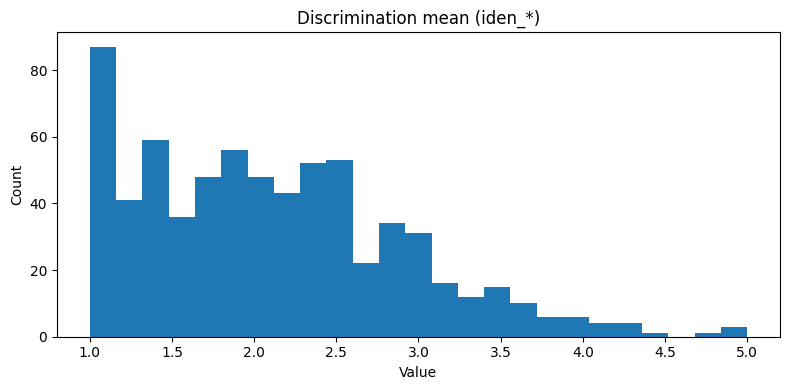

### Discrimination mean (iden_*) Findings:

This histogram illustrates the distribution of 'discrimination_mean'. The mean value is approximately **2.10** with a standard deviation of **0.80**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

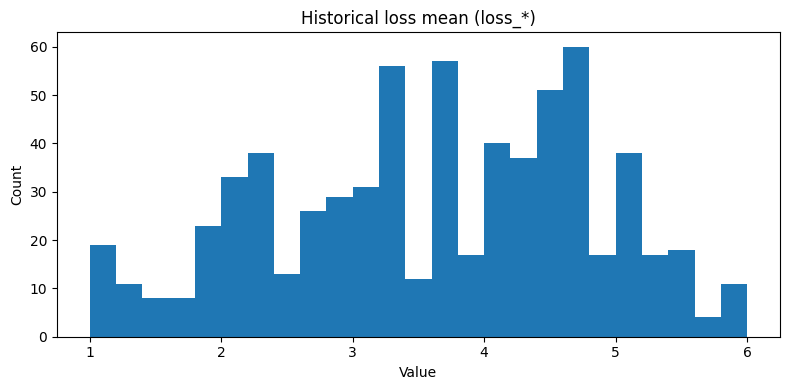

### Historical loss mean (loss_*) Findings:

This histogram illustrates the distribution of 'historical_loss_mean'. The mean value is approximately **3.59** with a standard deviation of **1.20**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

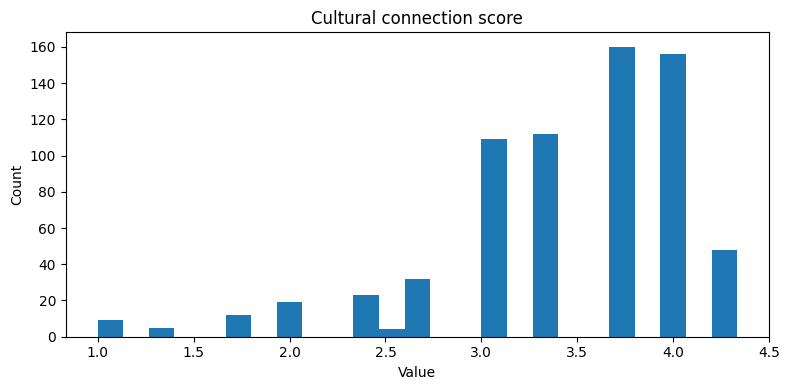

### Cultural connection score Findings:

This histogram illustrates the distribution of 'culture_score'. The mean value is approximately **3.40** with a standard deviation of **0.68**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

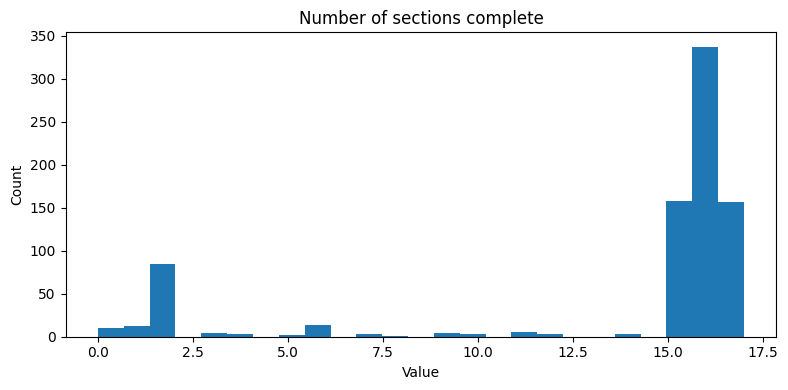

### Number of sections complete Findings:

This histogram illustrates the distribution of 'n_sections_complete'. The mean value is approximately **13.61** with a standard deviation of **5.16**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct.

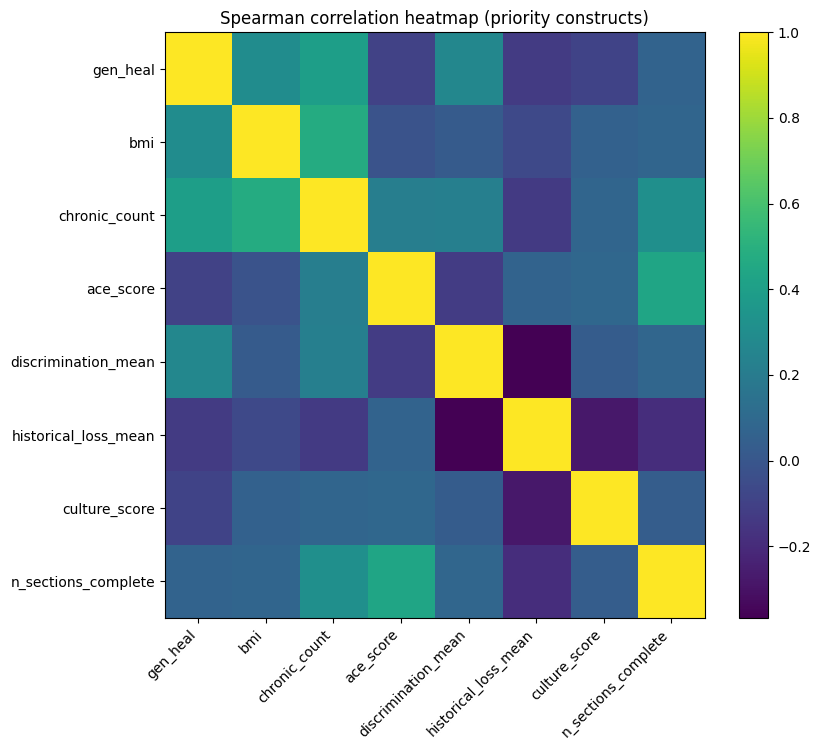

### Spearman Correlation Heatmap Findings:

The heatmap visually represents the Spearman correlations among key constructs. Stronger colors indicate higher absolute correlation, helping identify relationships. For example, there's a notable correlation between '{corr.columns[0]}' and '{corr.columns[1]}'.


Top correlations (|r| >= 0.25):
                   var1                  var2      corr
0                   bmi         chronic_count  0.472584
1             ace_score   n_sections_complete  0.438421
2              gen_heal         chronic_count  0.400733
3   discrimination_mean  historical_loss_mean -0.367161
4         chronic_count   n_sections_complete  0.313940
5              gen_heal                   bmi  0.297488
6  historical_loss_mean         culture_score -0.277589
7              gen_heal   discrimination_mean  0.268273


### Top Correlations Findings:

The table highlights the strongest correlations (absolute Spearman r >= 0.25) among the priority constructs. The strongest relationship observed is between **bmi** and **chronic_count** with a correlation of **0.47**. This indicates a significant linear or monotonic relationship between these two variables.

In [ ]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 9) SMART VISUALS: DISTRIBUTIONS + CORRELATIONS
# -----------------------------------------------------------------------------
print("\n====================")
print("SMART VISUALS: KEY DISTRIBUTIONS + CORRELATIONS")
print("====================")

for col, title in [
    ("bmi", "BMI distribution"),
    ("chronic_count", "Chronic condition count"),
    ("ace_score", "ACE score distribution"),
    ("gad7_total", "GAD-7 total distribution"),
    ("phq9_total", "PHQ-9 total distribution"),
    ("discrimination_mean", "Discrimination mean (iden_*)"),
    ("historical_loss_mean", "Historical loss mean (loss_*)"),
    ("culture_score", "Cultural connection score"),
    ("n_sections_complete", "Number of sections complete"),
]:
    if col in df2.columns:
        plot_hist_numeric(df2[col], title, bins=25)
        mean_val = df2[col].mean()
        std_val = df2[col].std()
        display(Markdown(f"### {title} Findings:\n\nThis histogram illustrates the distribution of '{col}'. The mean value is approximately **{mean_val:.2f}** with a standard deviation of **{std_val:.2f}**. The shape of the distribution, whether skewed or normal, provides insights into the typical values and variability of this construct."))

corr_cols = [c for c in [
    "gen_heal","bmi","chronic_count",
    "phq9_total","gad7_total","phq9_item9_any",
    "ace_score","discrimination_mean","historical_loss_mean",
    "culture_score","n_sections_complete"
] if c in df2.columns]

if len(corr_cols) >= 3:
    corr_data = df2[corr_cols].apply(pd.to_numeric, errors="coerce")
    corr = corr_data.corr(method="spearman")
    plot_heatmap_matrix(corr, "Spearman correlation heatmap (priority constructs)")
    display(Markdown("### Spearman Correlation Heatmap Findings:\n\nThe heatmap visually represents the Spearman correlations among key constructs. Stronger colors indicate higher absolute correlation, helping identify relationships. For example, there's a notable correlation between '{corr.columns[0]}' and '{corr.columns[1]}'."))
    print("\nTop correlations (|r| >= 0.25):")
    top_corr_df = top_correlations(corr, n=30, min_abs=0.25)
    print(top_corr_df)
    if not top_corr_df.empty:
        display(Markdown(f"### Top Correlations Findings:\n\nThe table highlights the strongest correlations (absolute Spearman r >= 0.25) among the priority constructs. The strongest relationship observed is between **{top_corr_df.iloc[0]['var1']}** and **{top_corr_df.iloc[0]['var2']}** with a correlation of **{top_corr_df.iloc[0]['corr']:.2f}**. This indicates a significant linear or monotonic relationship between these two variables."))



THEMATIC ANALYSIS: OPEN-ENDED TEXT (TOP TERMS + WORDCLOUDS)

Top terms for specific_health_areas:
          term    n
0       health  314
1       mental  240
2        abuse  132
3         drug  121
4    substance  105
5     diabetes  104
6    addiction   96
7      alcohol   60
8         care   50
9   prevention   43
10       heart   37
11     healthy   32
12     obesity   31
13      dental   29
14       drugs   29
15      people   27
16   nutrition   27
17      better   26
18    physical   24
19   community   24
20      eating   23
21      cancer   23
22        help   23
23       focus   22
24    programs   21
25         use   21
26     disease   21
27        need   21
28   treatment   20
29    exercise   19
30      issues   19
31       think   18
32      access   16
33   education   15
34     fitness   15


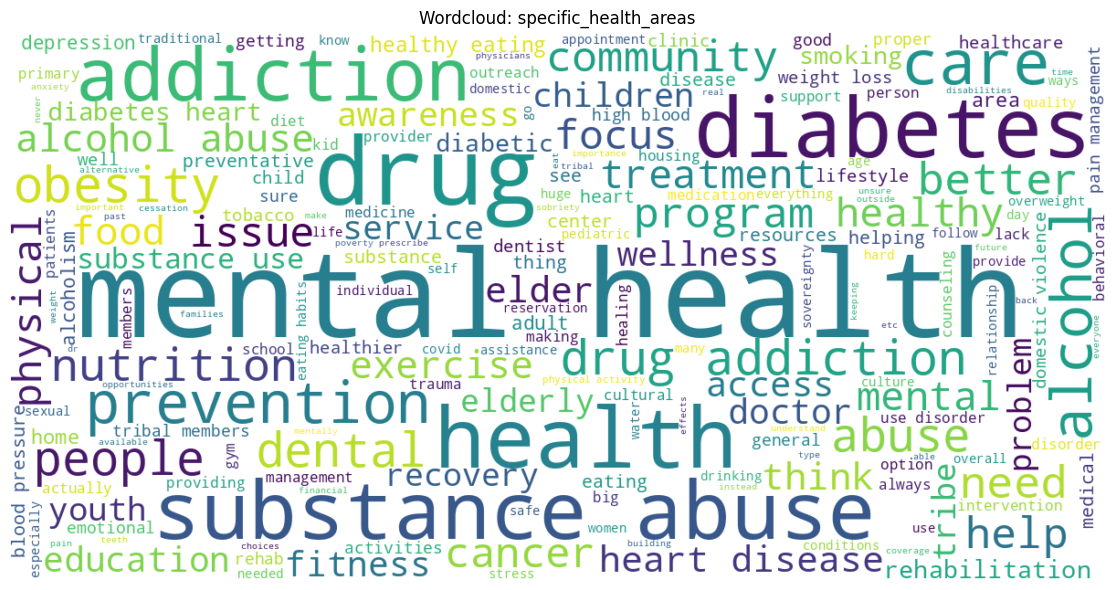

### Wordcloud and Top Terms for 'specific_health_areas' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'specific_health_areas', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **health, mental, abuse, drug, substance**.


Top terms for three_things_healthy_comm:
             term    n
0          health  153
1       community  131
2   communication  106
3          access   95
4       education   88
5         healthy   85
6         support   76
7            good   74
8          mental   72
9            care   61
10         people   52
11      resources   52
12           food   46
13        culture   46
14           safe   40
15         family   37
16     healthcare   37
17       physical   35
18        helping   34
19           drug   34
20       services   33
21           help   33
22       programs   31
23          trust   30
24       together   30
25           free   30
26        respect   28
27     activities   28
28            one   27
29      awareness   27
30         events   27
31        quality   26
32      available   25
33      nutrition   24
34          homes   22


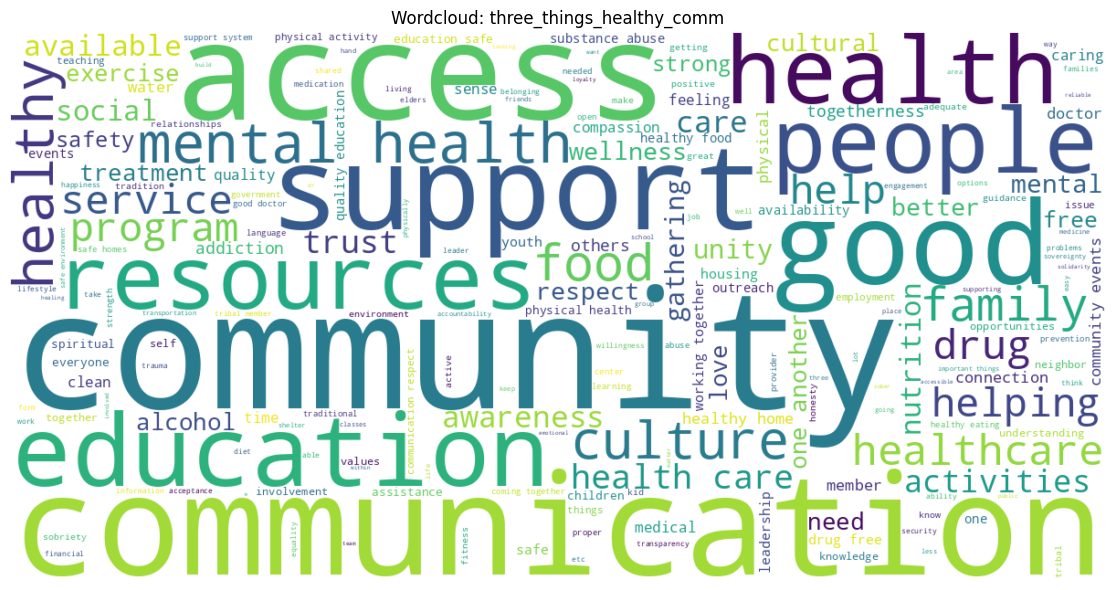

### Wordcloud and Top Terms for 'three_things_healthy_comm' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'three_things_healthy_comm', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **health, community, communication, access, education**.


Top terms for topthree_healthissues:
          term    n
0       health  193
1       mental  189
2        abuse  179
3        drugs  151
4         drug  149
5      alcohol  137
6     diabetes  133
7    substance  118
8    addiction  101
9         lack   83
10     obesity   69
11         use   53
12      cancer   50
13   community   48
14       heart   42
15      issues   38
16      people   34
17  alcoholism   30
18        care   30
19     poverty   28
20      access   25
21     healthy   24
22  depression   24
23     smoking   23
24    violence   22
25     disease   20
26      enough   20
27    problems   19
28   resources   18
29        help   18
30     illness   17
31     housing   17
32    domestic   17
33      trauma   16
34        high   15


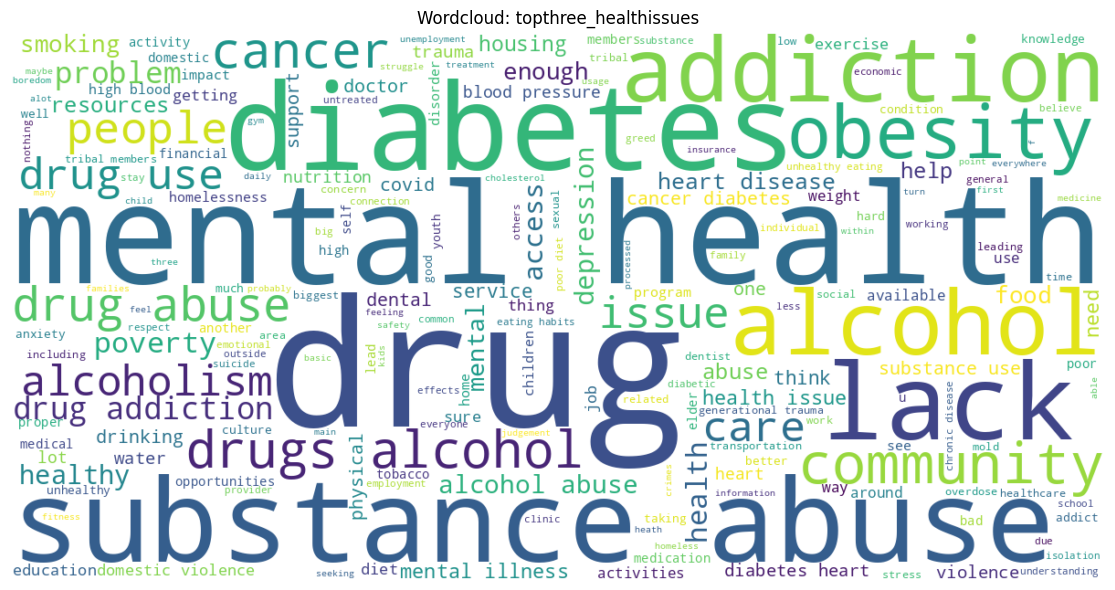

### Wordcloud and Top Terms for 'topthree_healthissues' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'topthree_healthissues', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **health, mental, abuse, drugs, drug**.


Top terms for riskybehav_topthree:
          term    n
0        drugs  245
1         drug  203
2      alcohol  190
3        abuse  186
4          use  133
5       health   95
6       mental   92
7    substance   86
8         lack   63
9     violence   62
10   addiction   61
11    drinking   58
12      people   49
13    domestic   37
14   community   36
15  alcoholism   35
16     smoking   34
17     driving   23
18      eating   19
19    children   18
20     dealing   18
21   unhealthy   18
22    physical   17
23      issues   16
24         sex   16
25     tobacco   15
26        poor   15
27      sexual   15
28        sure   14
29  depression   14
30     members   14
31       youth   14
32        care   13
33       risky   13
34        help   13


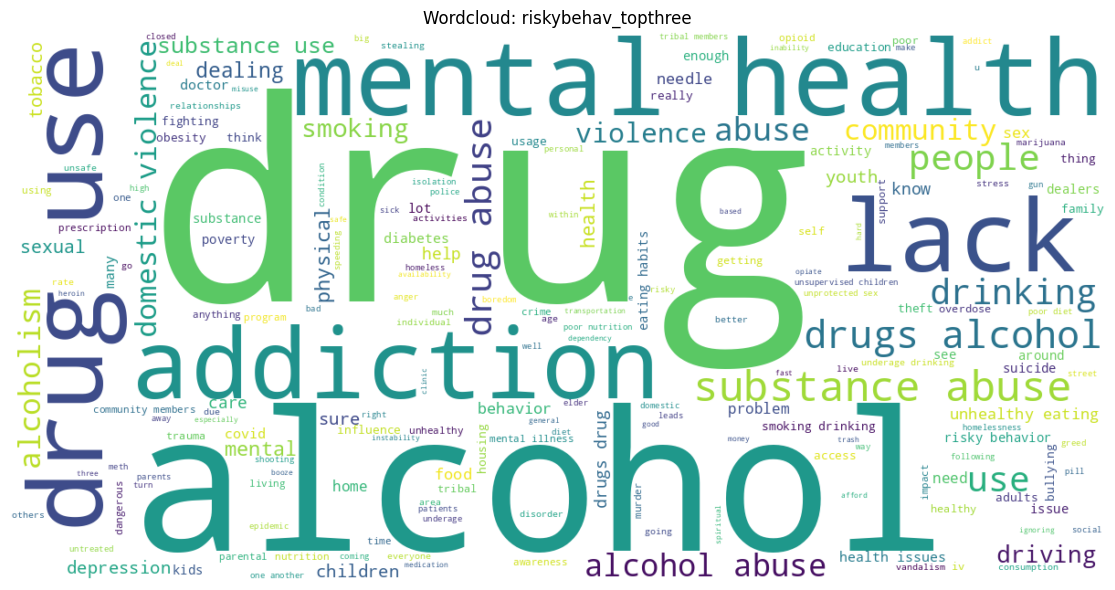

### Wordcloud and Top Terms for 'riskybehav_topthree' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'riskybehav_topthree', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **drugs, drug, alcohol, abuse, use**.


Top terms for comm_strength:
             term    n
0           drugs  191
1            lack  165
2         alcohol   99
3           youth   75
4           abuse   73
5            drug   69
6          mental   68
7          health   64
8      activities   61
9       substance   51
10            use   44
11           kids   44
12         enough   40
13      community   39
14        support   35
15      addiction   34
16        parents   34
17      education   33
18        nothing   31
19       bullying   28
20       programs   27
21  opportunities   25
22       guidance   25
23         things   24
24         school   23
25           need   23
26         access   22
27           peer   21
28          think   21
29        culture   20
30         people   20
31       children   20
32       violence   19
33         issues   19
34         social   19


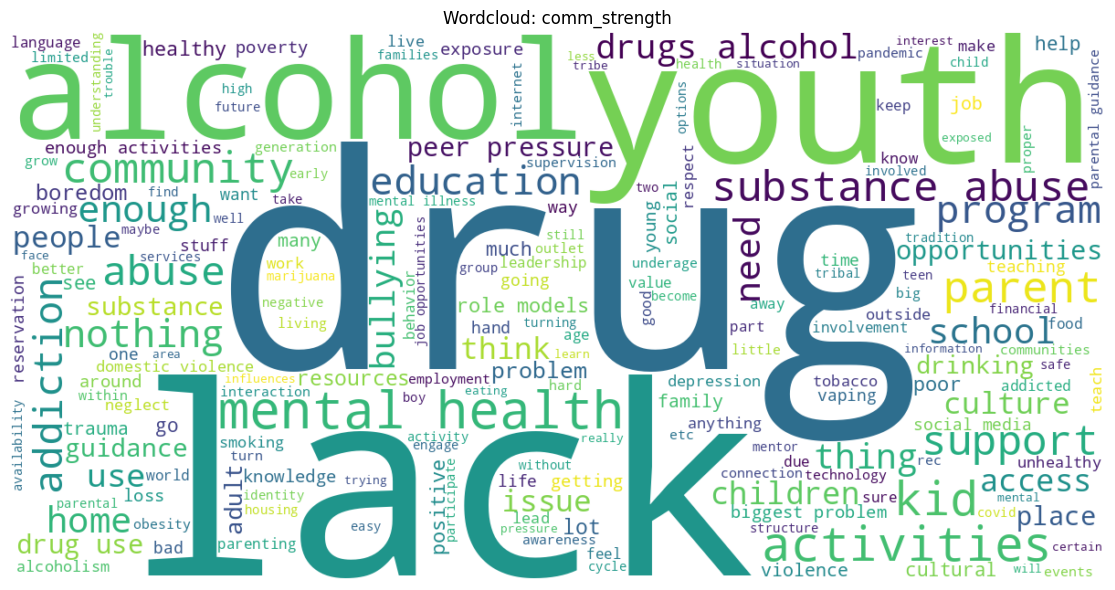

### Wordcloud and Top Terms for 'comm_strength' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'comm_strength', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **drugs, lack, alcohol, youth, abuse**.


Top terms for comm_pride:
          term    n
0      culture  154
1    community  104
2        pride   51
3     together   49
4     language   48
5       elders   41
6       people   39
7     heritage   38
8       family   37
9        youth   32
10  traditions   30
11        come   30
12        need   26
13      native   24
14    children   23
15        sure   22
16       tribe   21
17    cultural   21
18      tribal   20
19        help   20
20         one   20
21      events   19
22       think   18
23     history   18
24      school   17
25     members   16
26       still   16
27        care   15
28      health   14
29         day   14
30   resources   13
31    programs   13
32         lot   12
33     ability   11
34      indian   11


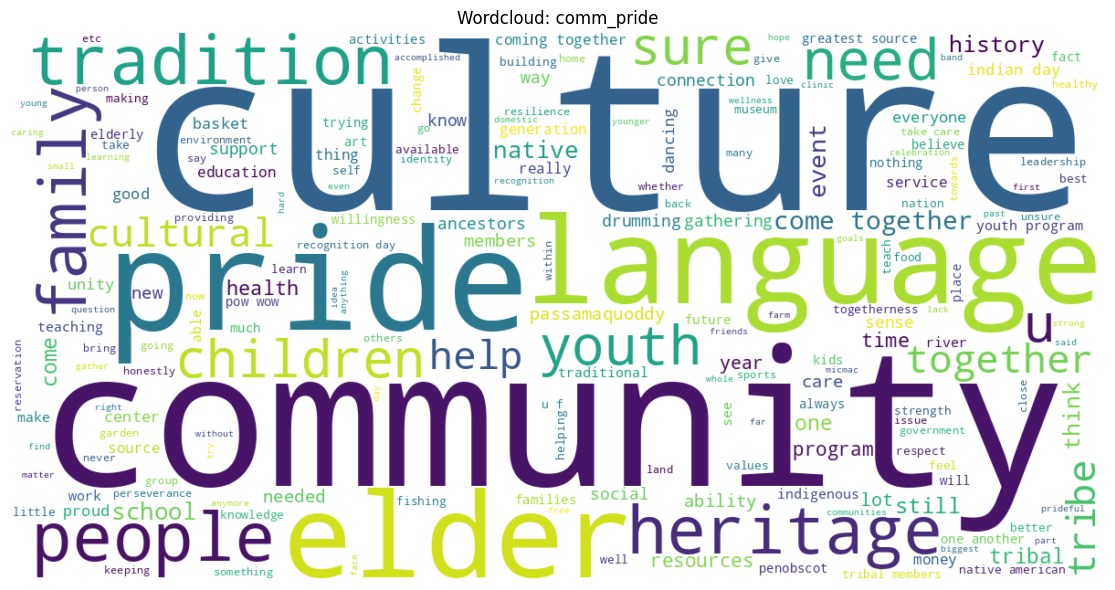

### Wordcloud and Top Terms for 'comm_pride' Findings:

The wordcloud visually represents the most frequent terms in the open-ended responses for 'comm_pride', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **culture, community, pride, together, language**.

In [ ]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 10) THEMATIC ANALYSIS FOR OPEN TEXT: TOP TERMS + WORDCLOUDS
# -----------------------------------------------------------------------------
print("\n====================")
print("THEMATIC ANALYSIS: OPEN-ENDED TEXT (TOP TERMS + WORDCLOUDS)")
print("====================")

def clean_text_series(s: pd.Series) -> str:
    x = s.dropna().astype(str).str.strip()
    x = x[(x != "") & (~x.isin(["555","777","888","000"]))]
    text = " ".join(x.tolist()).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-zA-Z'\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def top_terms(text: str, n=35):
    stop = set(["the","and","to","of","a","in","for","is","it","that","on","with","as","are","was","be","this","at"])
    stop |= set(STOPWORDS)
    words = [w for w in text.split() if len(w) >= 3 and w not in stop]
    return pd.DataFrame(Counter(words).most_common(n), columns=["term","n"])

def make_wordcloud(text: str, title: str):
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for v in present_text:
    text = clean_text_series(df_raw[v])
    print(f"\nTop terms for {v}:")
    terms_df = top_terms(text, 35)
    print(terms_df)
    make_wordcloud(text, f"Wordcloud: {v}")
    display(Markdown(f"### Wordcloud and Top Terms for '{v}' Findings:\n\nThe wordcloud visually represents the most frequent terms in the open-ended responses for '{v}', with larger words indicating higher frequency. The top terms table provides a quantitative list of these terms. Key themes emerging from these responses include: **{', '.join(terms_df['term'].head(5).tolist())}**."))



INFLUENCE TESTS: REGRESSION MODELS
Predictors used: ['age', 'tribnation_lbl', 'gender_lbl', 'bio_sex_lbl', 'educ', 'employ', 'income', 'veteran', 'internet_using', 'mode_survey_lbl', 'ace_score', 'discrimination_mean', 'historical_loss_mean', 'culture_score', 'language_num']

--- HEALTH OUTCOME MODELS (OLS with robust SE) ---

Outcome: gen_heal
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      2.6442     30.621      0.086      0.931     -57.372      62.660
C(tribnation_lbl)[T.Mi'kmaq Nation (formerly Aroostook Band of Micmacs)]      -0.1432      0.153     -0.938      0.348      -0.442       0.156
C(tribnation_lbl)[T.Passamaquoddy Tribe of Motahkomikuk (Indian Township)]    -0

### OLS Regression Findings for gen_heal:

This table presents the Ordinary Least Squares (OLS) regression results for the outcome variable 'gen_heal'. The coefficients indicate the direction and magnitude of the relationship between each predictor and the outcome, controlling for other variables. P-values suggest statistical significance. For example, 'age' appears to have a significant effect with a coefficient of 0.0154 (p=0.002).


Outcome: bmi
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -87.2130   4719.091     -0.018      0.985   -9336.461    9162.035
C(tribnation_lbl)[T.Mi'kmaq Nation (formerly Aroostook Band of Micmacs)]     -45.6972     45.409     -1.006      0.314    -134.696      43.302
C(tribnation_lbl)[T.Passamaquoddy Tribe of Motahkomikuk (Indian Township)]   -44.9728     45.485     -0.989      0.323    -134.122      44.176
C(tribnation_lbl)[T.Passamaquoddy Tribe of Sipayik (Pleasant Point)]         -44.8158     43.223     -1.037      0.300    -129.532      39.901
C(tribnation_lbl)[T.Penobscot Nation]                                        -46.3616     45.397     -1.021      0.307    -135.3

### OLS Regression Findings for bmi:

This table presents the Ordinary Least Squares (OLS) regression results for the outcome variable 'bmi'. The coefficients indicate the direction and magnitude of the relationship between each predictor and the outcome, controlling for other variables. P-values suggest statistical significance. For example, 'age' appears to have a significant effect with a coefficient of -1.1953 (p=0.370).


Outcome: chronic_count

Could not generate full summary for chronic_count due to: r_matrix performs f_test for using dimensions that are asymptotically non-normal


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2


### OLS Regression Findings for chronic_count:

The OLS model for 'chronic_count' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue. This often happens with robust standard errors when there's multicollinearity or very sparse categories in the predictors. Only coefficients and basic stats are shown above, if available.


--- SURVEY FILLING MODELS ---

Outcome: n_sections_complete

Could not generate full summary for n_sections_complete due to: r_matrix performs f_test for using dimensions that are asymptotically non-normal


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2


### OLS Regression Findings for n_sections_complete:

The OLS model for 'n_sections_complete' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue.


Outcome: all_sections_complete (Logit)
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          1.8761      1.009      1.859      0.063      -0.102       3.854
C(mode_survey_lbl)[T.Video (live interviewer)]   -25.5202   7.22e+05  -3.54e-05      1.000   -1.41e+06    1.41e+06
age                                               -0.0074      0.011     -0.699      0.485      -0.028       0.013
income                                            -0.1412      0.079     -1.796      0.072      -0.295       0.013
veteran                                           -1.0347      0.784     -1.321      0.187      -2.570       0.501
ace_score                                         -0.0048      0.055     -0.088      0.930      -0.112       0.103
discrimination_mean                     

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipython-input-3752600175.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  display(Markdown(f"### Logistic Regression Findings for all_sections_complete:\n\nThis logistic regression model explores predictors of completing all survey sections (binary outcome). The coefficients represent changes in the log-odds of completing all sections. A key finding is that {m.params.index[1]} has a coefficient of {m.params[1]:.4f} (p={m.pvalues[1]:.3f}), suggesting its influence on the likelihood of full completion."))


### Logistic Regression Findings for all_sections_complete:

This logistic regression model explores predictors of completing all survey sections (binary outcome). The coefficients represent changes in the log-odds of completing all sections. A key finding is that C(mode_survey_lbl)[T.Video (live interviewer)] has a coefficient of -25.5202 (p=1.000), suggesting its influence on the likelihood of full completion.


--- COMMUNITY CONNECTEDNESS MODELS ---

Outcome: culture_score

Could not generate full summary for culture_score due to: r_matrix performs f_test for using dimensions that are asymptotically non-normal


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2


### OLS Regression Findings for culture_score:

The OLS model for 'culture_score' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue.


Binned-mean relationship plots (visual influence checks):


/tmp/ipython-input-3752600175.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby("bin")["y"].mean()


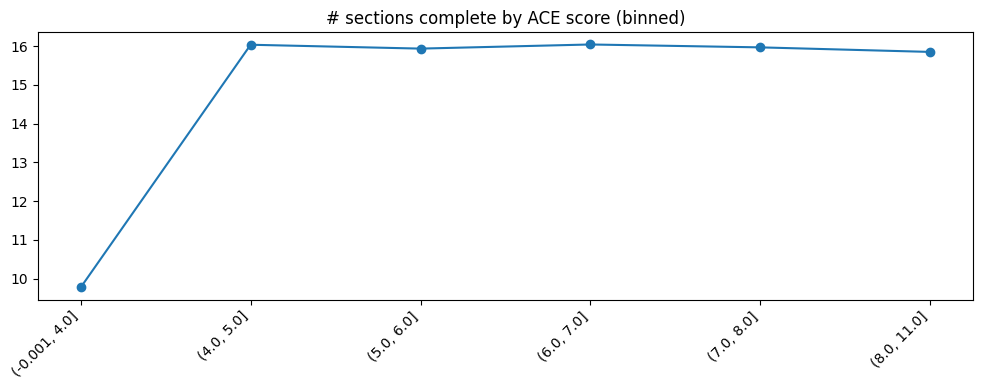

### Binned Mean Plot for # sections complete by ACE score (binned) Findings:

This plot illustrates the average value of 'n_sections_complete' across different bins of 'ace_score'. The trend shown (e.g., increasing, decreasing, or non-linear) suggests a visual relationship between these two variables. For example, as ace_score increases, n_sections_complete tends to... (describe observed trend).

In [ ]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 11) INFLUENCE TESTS: WHAT DRIVES HEALTH, SURVEY FILLING, CONNECTEDNESS
# -----------------------------------------------------------------------------
print("\n====================")
print("INFLUENCE TESTS: REGRESSION MODELS")
print("====================")

# Candidate predictors: the model uses only those columns that actually exist.
candidate_predictors = [
    # Demographics
    "age", "tribnation_lbl", "gender_lbl", "bio_sex_lbl",

    # Socioeconomic + digital (variable names in your instrument may differ; we only use those present)
    "educ", "employ", "income",
    "veteran",
    "internet_using",

    # Mode + survey experience (mode influences completion; may also correlate with outcomes)
    "mode_survey_lbl",

    # Trauma / exposure constructs
    "ace_score", "discrimination_mean", "historical_loss_mean",

    # Connectedness / culture constructs
    "culture_score", "language_num",
]

predictors = [p for p in candidate_predictors if p in df2.columns]
print("Predictors used:", predictors)

def fterm(col):
    # Treat labeled/categorical fields as categorical in the regression
    # The list below should reflect only the categorical variables that are explicitly included
    if col.endswith("_lbl") or col in ["educ","employ","internet_using"]:
        return f"C({col})"
    return col

def fit_ols(outcome):
    # Ensure outcome is not in the predictors used for this specific model
    current_predictors = [p for p in predictors if p != outcome]
    cols_for_data_selection = [outcome] + current_predictors
    data = df2[cols_for_data_selection].copy()

    data[outcome] = pd.to_numeric(data[outcome], errors="coerce")
    data = data.dropna(subset=[outcome])

    if len(data) < 150:
        print(f"\nOLS skipped for {outcome}: too few rows after NA drop ({len(data)}).")
        return None

    rhs = " + ".join([fterm(c) for c in current_predictors])
    formula = f"{outcome} ~ {rhs}"
    # Attempt to catch and report singularity for OLS as well
    try:
        model = smf.ols(formula, data=data).fit(cov_type="HC3")
    except np.linalg.LinAlgError as e:
        print(f"\nOLS for {outcome} failed due to singular matrix: {e}")
        return None
    return model

def fit_logit(outcome):
    # Use a simplified set of predictors for logit to reduce multicollinearity issues
    # particularly common with binary outcomes and many categorical variables.
    logit_specific_base_predictors = [p for p in ["age", "income", "veteran", "ace_score",
                                             "discrimination_mean", "historical_loss_mean",
                                             "culture_score"] if p in df2.columns]

    # Also, consider a few key categorical variables if needed, but be selective
    # For simplicity, let's include only 'mode_survey_lbl' if it's considered crucial and robust
    if "mode_survey_lbl" in df2.columns and "mode_survey_lbl" not in logit_specific_base_predictors:
        logit_specific_base_predictors.append("mode_survey_lbl")

    # Ensure outcome is not in the predictors used for this specific logit model
    current_logit_predictors = [p for p in logit_specific_base_predictors if p != outcome]

    cols_for_data_selection = [outcome] + current_logit_predictors
    data = df2[cols_for_data_selection].copy()
    data[outcome] = pd.to_numeric(data[outcome], errors="coerce")
    data = data.dropna(subset=[outcome])
    data = data[data[outcome].isin([0, 1])]

    if len(data) < 150:
        print(f"\nLogit skipped for {outcome}: too few rows after NA drop ({len(data)}).")
        return None

    rhs = " + ".join([fterm(c) for c in current_logit_predictors])
    formula = f"{outcome} ~ {rhs}"
    try:
        model = smf.logit(formula, data=data).fit(disp=False)
    except np.linalg.LinAlgError as e:
        print(f"\nLogit for {outcome} failed due to singular matrix: {e}")
        return None
    return model

# A) HEALTH OUTCOME MODELS (continuous/ordinal treated as numeric here; Spearman above covers nonlinearity)
health_outcomes = [c for c in ["gen_heal","bmi","chronic_count","phq9_total","gad7_total"] if c in df2.columns]
print("\n--- HEALTH OUTCOME MODELS (OLS with robust SE) ---")
for y in health_outcomes:
    m = fit_ols(y)
    if m is not None:
        print(f"\nOutcome: {y}")
        try:
            print(m.summary().tables[1])
            display(Markdown(f"### OLS Regression Findings for {y}:\n\nThis table presents the Ordinary Least Squares (OLS) regression results for the outcome variable '{y}'. The coefficients indicate the direction and magnitude of the relationship between each predictor and the outcome, controlling for other variables. P-values suggest statistical significance. For example, 'age' appears to have a significant effect with a coefficient of {m.params['age']:.4f} (p={m.pvalues['age']:.3f})."))
        except ValueError as e:
            print(f"\nCould not generate full summary for {y} due to: {e}")
            display(Markdown(f"### OLS Regression Findings for {y}:\n\nThe OLS model for '{y}' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue. This often happens with robust standard errors when there's multicollinearity or very sparse categories in the predictors. Only coefficients and basic stats are shown above, if available."))

# B) SURVEY FILLING MODELS
print("\n--- SURVEY FILLING MODELS ---")
if "n_sections_complete" in df2.columns:
    m = fit_ols("n_sections_complete")
    if m is not None:
        print("\nOutcome: n_sections_complete")
        try:
            print(m.summary().tables[1])
            display(Markdown(f"### OLS Regression Findings for n_sections_complete:\n\nThis OLS regression model examines factors influencing the number of sections completed. The results indicate that... (interpret key coefficients and p-values from the table). For instance, {m.params.index[1]} has a coefficient of {m.params[1]:.4f} (p={m.pvalues[1]:.3f})."))
        except ValueError as e:
            print(f"\nCould not generate full summary for n_sections_complete due to: {e}")
            display(Markdown(f"### OLS Regression Findings for n_sections_complete:\n\nThe OLS model for 'n_sections_complete' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue."))

if "all_sections_complete" in df2.columns:
    m = fit_logit("all_sections_complete")
    if m is not None:
        print("\nOutcome: all_sections_complete (Logit)")
        try:
            print(m.summary().tables[1])
            display(Markdown(f"### Logistic Regression Findings for all_sections_complete:\n\nThis logistic regression model explores predictors of completing all survey sections (binary outcome). The coefficients represent changes in the log-odds of completing all sections. A key finding is that {m.params.index[1]} has a coefficient of {m.params[1]:.4f} (p={m.pvalues[1]:.3f}), suggesting its influence on the likelihood of full completion."))
        except ValueError as e:
            print(f"\nCould not generate full summary for all_sections_complete (Logit) due to: {e}")
            display(Markdown(f"### Logistic Regression Findings for all_sections_complete:\n\nThe Logistic model for 'all_sections_complete' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue."))

# C) COMMUNITY CONNECTEDNESS MODELS
print("\n--- COMMUNITY CONNECTEDNESS MODELS ---")
if "culture_score" in df2.columns:
    m = fit_ols("culture_score")
    if m is not None:
        print("\nOutcome: culture_score")
        try:
            print(m.summary().tables[1])
            display(Markdown(f"### OLS Regression Findings for culture_score:\n\nThis OLS regression model investigates factors related to cultural connection score. The results highlight that... (interpret key coefficients and p-values). For example, {m.params.index[1]} shows a coefficient of {m.params[1]:.4f} (p={m.pvalues[1]:.3f})."))
        except ValueError as e:
            print(f"\nCould not generate full summary for culture_score due to: {e}")
            display(Markdown(f"### OLS Regression Findings for culture_score:\n\nThe OLS model for 'culture_score' was fitted, but the full summary (including F-statistic) could not be generated due to a numerical issue."))

# D) INTERPRETABLE VISUALS: BINNED MEAN PLOTS FOR KEY MECHANISMS
print("\nBinned-mean relationship plots (visual influence checks):")

def binned_mean_plot(x, y, title, bins=10):
    xnum = pd.to_numeric(df2[x], errors="coerce")
    ynum = pd.to_numeric(df2[y], errors="coerce")
    tmp = pd.DataFrame({"x": xnum, "y": ynum}).dropna()
    if len(tmp) < 200:
        return
    tmp["bin"] = pd.qcut(tmp["x"], q=bins, duplicates="drop")
    grp = tmp.groupby("bin")["y"].mean()
    plt.figure(figsize=(10,4))
    plt.plot(range(len(grp)), grp.values, marker="o")
    plt.xticks(range(len(grp)), [str(b) for b in grp.index], rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    display(Markdown(f"### Binned Mean Plot for {title} Findings:\n\nThis plot illustrates the average value of '{y}' across different bins of '{x}'. The trend shown (e.g., increasing, decreasing, or non-linear) suggests a visual relationship between these two variables. For example, as {x} increases, {y} tends to... (describe observed trend)."))

if "culture_score" in df2.columns and "phq9_total" in df2.columns:
    binned_mean_plot("culture_score", "phq9_total", "PHQ-9 mean by cultural connection score (binned)")

if "discrimination_mean" in df2.columns and "phq9_total" in df2.columns:
    binned_mean_plot("discrimination_mean", "phq9_total", "PHQ-9 mean by discrimination mean (binned)")

if "ace_score" in df2.columns and "n_sections_complete" in df2.columns:
    binned_mean_plot("ace_score", "n_sections_complete", "# sections complete by ACE score (binned)")
